In [ ]:
!python --version

Python 3.10.14


In [ ]:
!pip install pyspark -U
!pip install wordcloud -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 5.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840629 sha256=752a5512ae77aec631bf759778cce56befd7a88361e08e67f295d076573454b5
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 8.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: wordcloud
    Found existing installation: wordcloud 1.9.3
    Uninstalling wordcloud-1.9.3:
      Successfully uninstalled wordcloud-1.9.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.10.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import explode, col, count, avg, lower, initcap, to_date, date_format, when

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy as np

In [ ]:
# Initialize Spark session
spark = SparkSession.builder.appName("JobOffersAnalysis").getOrCreate()

# # Load JSON data
# data_path_2021 = [
#     "/kaggle/input/justjoinit-job-offers-data-2021-10-2023-09/2022-10/*.json",
#     "/kaggle/input/justjoinit-job-offers-data-2021-10-2023-09/2022-11/*.json",
#     "/kaggle/input/justjoinit-job-offers-data-2021-10-2023-09/2022-12/*.json"
# ]
# # reading all the available data for the years of 2021
# df = spark.read.json(data_path_2021)

# reading all the available data for the years of 2021, 2022 and 2023
df = spark.read.json("/kaggle/input/justjoinit-job-offers-data-2021-10-2023-09/*/*.json")

# Show the schema of the DataFrame
df.printSchema()

# # Display the first few rows of the DataFrame
# df.show()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/07 17:13:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- address_text: string (nullable = true)
 |-- city: string (nullable = true)
 |-- company_logo_url: string (nullable = true)
 |-- company_name: string (nullable = true)
 |-- company_size: string (nullable = true)
 |-- company_url: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- display_offer: boolean (nullable = true)
 |-- employment_types: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- salary: struct (nullable = true)
 |    |    |    |-- currency: string (nullable = true)
 |    |    |    |-- from: long (nullable = true)
 |    |    |    |-- to: long (nullable = true)
 |    |    |-- type: string (nullable = true)
 |-- experience_level: string (nullable = true)
 |-- id: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- marker_icon: string (nullable = true)
 |-- multilocation: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    | 

### Filter to avoid counting the same offer multiple times.

In [ ]:
min_published_at_df = df.groupBy("id").agg(F.min("published_at").alias("min_published_at"))

min_published_at_df = min_published_at_df.withColumnRenamed('id', 'min_id')

filtered_df = df.join(min_published_at_df,
                      (df.id == min_published_at_df.min_id) & (df.published_at == min_published_at_df.min_published_at))

df = filtered_df.drop('min_published_at','min_id')

In [ ]:
filtered_df = df.filter((df.title.rlike("(?i).*big.*") | df.title.rlike("(?i).*analyst.*")) & df.title.rlike("(?i).*data.*"))


In [ ]:
filtered_df.count()

87840

In [ ]:
df = filtered_df

In [ ]:
# Convert title column to lowercase, find unique roles, and order them
unique_roles = df.select(initcap("title").alias("title")).distinct().orderBy("title")
unique_roles.show(truncate=False)

+------------------------------------------------------+
|title                                                 |
+------------------------------------------------------+
| Data Analyst (trust, Safety & Cx Automation Products)|
|(big Data) Hadoop/cloudera Developer                  |
|(senior) People Data Analyst                          |
|(senior)environmental Data Analyst                    |
|Administrator Big Data                                |
|Administrator Bigdata                                 |
|Akademia It - Data Analyst                            |
|Alm Data Analyst                                      |
|Analityk Big Data                                     |
|Analityk Danych (big Data)                            |
|Analityk Danych (data Analyst)                        |
|Analityk Danych / Data Analyst                        |
|Analityk Danych Big Data                              |
|Analityk Systemowy Big Data                           |
|Application Specialist In Big 

#### Extract skills

> Dodaj cytat blokowy



In [ ]:
skills_df = df.select("published_at", "country_code", initcap("city").alias("city"), "latitude", "longitude", initcap("title").alias("title"), explode("skills").alias("skill"), "remote", "employment_types","experience_level")
skills_df.show(truncate=False)

+------------------------+------------+--------+----------+----------+-------------------------------+------------------------------+------+--------------------------------------------------------------+----------------+
|published_at            |country_code|city    |latitude  |longitude |title                          |skill                         |remote|employment_types                                              |experience_level|
+------------------------+------------+--------+----------+----------+-------------------------------+------------------------------+------+--------------------------------------------------------------+----------------+
|2022-09-16T13:00:09.523Z|PL          |Warszawa|52.2302457|21.0039223|Junior Big Data Engineer       |{2, SQL}                      |true  |[{{pln, 18000, 22000}, b2b}]                                  |junior          |
|2022-09-16T13:00:09.523Z|PL          |Warszawa|52.2302457|21.0039223|Junior Big Data Engineer       |{2, Scala}    

#### Recode published data to quarters

In [ ]:
skills_df = skills_df.withColumn("published_at_year", F.date_format(F.col("published_at"), "yyyy"))

skills_df = skills_df.withColumn( "quarter",
    F.when((F.month(F.col("published_at")).between(1, 3)), "Q1")
    .when((F.month(F.col("published_at")).between(4, 6)), "Q2")
    .when((F.month(F.col("published_at")).between(7, 9)), "Q3")
    .when((F.month(F.col("published_at")).between(10, 12)), "Q4")
)

skills_df.show(truncate=False)

+------------------------+------------+--------+----------+----------+-------------------------------+------------------------------+------+--------------------------------------------------------------+----------------+-----------------+-------+
|published_at            |country_code|city    |latitude  |longitude |title                          |skill                         |remote|employment_types                                              |experience_level|published_at_year|quarter|
+------------------------+------------+--------+----------+----------+-------------------------------+------------------------------+------+--------------------------------------------------------------+----------------+-----------------+-------+
|2022-09-16T13:00:09.523Z|PL          |Warszawa|52.2302457|21.0039223|Junior Big Data Engineer       |{2, SQL}                      |true  |[{{pln, 18000, 22000}, b2b}]                                  |junior          |2022             |Q3     |
|2022-09-16T

#### Recoding same skills with different names

In [ ]:
flattened_skills = skills_df.select("published_at_year", "quarter", "city", "latitude", "longitude", "title", initcap(col("skill.name")).alias("skill_name"), col("skill.level").alias("skill_level"), "employment_types")

flattened_skills = flattened_skills.withColumn(
    "skill_name",
    when(col("skill_name") == "Powerbi", "Power Bi").otherwise(col("skill_name"))
)

flattened_skills = flattened_skills.withColumn(
    "skill_name",
    when(col("skill_name") == "Pyspark", "Apache Spark").otherwise(col("skill_name"))
)

flattened_skills = flattened_skills.withColumn(
    "skill_name",
    when(col("skill_name") == "Spark", "Apache Spark").otherwise(col("skill_name"))
)

flattened_skills = flattened_skills.withColumn(
    "skill_name",
    when(col("skill_name") == "Excel", "Ms Excel").otherwise(col("skill_name"))
)
flattened_skills = flattened_skills.withColumn(
    "skill_name",
    when(col("skill_name") == "Google Cloud", "Google Cloud Platform").otherwise(col("skill_name"))
)

flattened_skills = flattened_skills.withColumn(
    "skill_name",
    when(col("skill_name") == "Hadoop Or Cloud Solutions", "Hadoop").otherwise(col("skill_name"))
)

flattened_skills = flattened_skills.withColumn(
    "skill_name",
    when(col("skill_name") == "Microsoft Azure Cloud", "Azure").otherwise(col("skill_name"))
)

flattened_skills = flattened_skills.withColumn(
    "skill_name",
    when(col("skill_name") == "Sql Db", "Sql").otherwise(col("skill_name"))
)

flattened_skills = flattened_skills.withColumn(
    "skill_name",
    when(col("skill_name") == "Azure Databricks", "Azure").otherwise(col("skill_name"))
)

flattened_skills = flattened_skills.withColumn(
    "skill_name",
    when(col("skill_name") == "Azure Data Stack", "Azure").otherwise(col("skill_name"))
)
flattened_skills.show(truncate=False)

+-----------------+-------+--------+----------+----------+-------------------------------+-------------------------+-----------+--------------------------------------------------------------+
|published_at_year|quarter|city    |latitude  |longitude |title                          |skill_name               |skill_level|employment_types                                              |
+-----------------+-------+--------+----------+----------+-------------------------------+-------------------------+-----------+--------------------------------------------------------------+
|2022             |Q3     |Warszawa|52.2302457|21.0039223|Junior Big Data Engineer       |Sql                      |2          |[{{pln, 18000, 22000}, b2b}]                                  |
|2022             |Q3     |Warszawa|52.2302457|21.0039223|Junior Big Data Engineer       |Scala                    |2          |[{{pln, 18000, 22000}, b2b}]                                  |
|2022             |Q3     |Warszawa|52.2

### Calculating average salary for each skill and level

In [ ]:
average_salary_skill = skills_df.select("published_at_year", "quarter", "city", "latitude", "longitude", "title", initcap(col("skill.name")).alias("skill_name"), col("skill.level").alias("skill_level"), explode("employment_types").alias("employment"))

df_salaries = average_salary_skill.select(
    "skill_name",
    "skill_level",
    col("employment.salary.currency").alias("employment_currency"),
    col("employment.type").alias("employment_type"),
    col("employment.salary.from").cast("int").alias("salary_from"),
    col("employment.salary.to").cast("int").alias("salary_to")
)

df_salaries = df_salaries.filter(
    (F.col("employment_currency") == "pln") &
    (F.col("salary_from").isNotNull()) &
    (F.col("salary_to").isNotNull())
)


df_salaries = df_salaries.withColumn(
    "avg_salary",
    (F.col("salary_from") + F.col("salary_to")) / 2
)


df_salaries = df_salaries.groupBy("skill_name", "skill_level").agg(
    F.avg("avg_salary").alias("avg_salary"),
    F.count("*").alias("offer_count")
)

df_salaries.show(truncate=False)

+-------------------+-----------+------------------+-----------+
|skill_name         |skill_level|avg_salary        |offer_count|
+-------------------+-----------+------------------+-----------+
|Sql                |3          |16557.463453631794|8756       |
|K8s                |1          |19500.0           |134        |
|Python             |4          |21832.126033800792|8343       |
|Python             |3          |17006.741629816803|7915       |
|Elk                |4          |17500.0           |513        |
|Power Bi           |2          |9857.94701986755  |906        |
|Analysing Data     |3          |10500.0           |1064       |
|Statistics         |4          |13238.613861386139|606        |
|Sql                |5          |27056.64789139226 |1731       |
|Mss Office         |4          |12500.0           |24         |
|Sql                |2          |10959.240395170144|1822       |
|Ms Excel           |3          |10417.909238249595|617        |
|Applied Statistics |4   

### Calculating average salary for each skill and level of expertise

In [ ]:
average_salary_skill_experience = skills_df.select("experience_level", initcap(col("skill.name")).alias("skill_name"), col("skill.level").alias("skill_level"), explode("employment_types").alias("employment"))


df_salaries_experience = average_salary_skill_experience.select(
    "experience_level",
    "skill_name",
    "skill_level",
    col("employment.salary.currency").alias("employment_currency"),
    col("employment.type").alias("employment_type"),
    col("employment.salary.from").cast("int").alias("salary_from"),
    col("employment.salary.to").cast("int").alias("salary_to")
)

df_salaries_experience = df_salaries_experience.filter(
    (F.col("employment_currency") == "pln") &
    (F.col("salary_from").isNotNull()) &
    (F.col("salary_to").isNotNull())
)


df_salaries_experience = df_salaries_experience.withColumn(
    "avg_salary",
    (F.col("salary_from") + F.col("salary_to")) / 2
)


df_salaries_experience = df_salaries_experience.groupBy("skill_name", "experience_level").agg(
    F.avg("avg_salary").alias("avg_salary"),
    F.count("*").alias("offer_count")
)

df_salaries_experience.show(truncate=False)

+-------------------------+----------------+------------------+-----------+
|skill_name               |experience_level|avg_salary        |offer_count|
+-------------------------+----------------+------------------+-----------+
|Google Analytics         |mid             |11670.822429906542|1070       |
|Data Modeling            |senior          |24554.459203036055|527        |
|Big Data Technologies    |senior          |17500.0           |513        |
|Sql                      |senior          |22832.38286697855 |11329      |
|Big Data                 |senior          |24922.779948793963|7421       |
|Scala                    |mid             |19529.330365659778|3145       |
|Analytical Thinking      |mid             |15812.36220472441 |889        |
|Ddi                      |mid             |27500.0           |29         |
|Python                   |senior          |23097.58993760786 |7533       |
|Data Analysis            |junior          |12777.966101694916|118        |
|Looker     

# Analysis

### Identify the most Top 20 Most Frequently Required Skills

+------------+-----+
|skill_name  |count|
+------------+-----+
|Sql         |39948|
|Python      |24163|
|Big Data    |13786|
|Scala       |12730|
|Apache Spark|11753|
|Power Bi    |10672|
|Java        |10516|
|English     |8169 |
|Hadoop      |5938 |
|Ms Excel    |5684 |
|Aws         |4914 |
|Data        |4869 |
|Etl         |4340 |
|Tableau     |3995 |
|R           |3183 |
|Azure       |3178 |
|Nosql       |3018 |
|Linux       |2825 |
|Cloud       |2446 |
|Sap         |2097 |
+------------+-----+
only showing top 20 rows



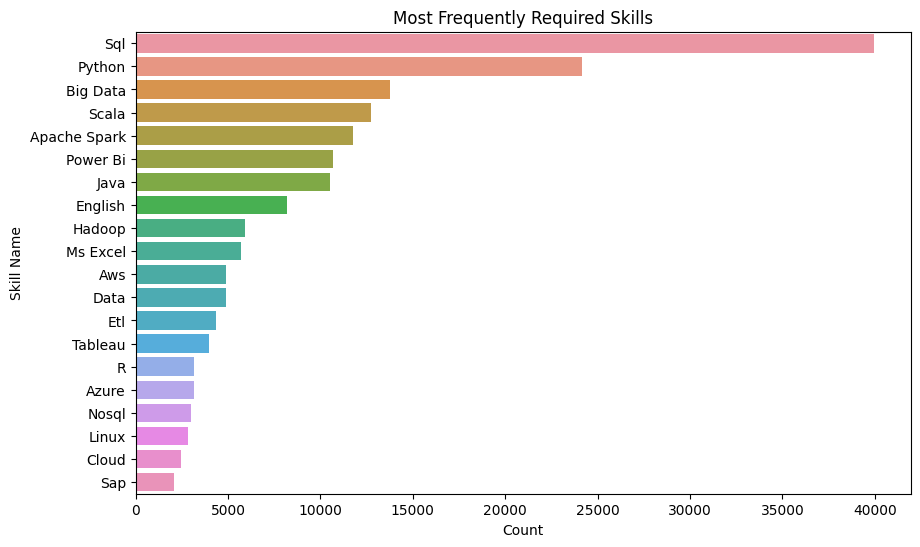

In [ ]:
# Most frequently required skills
most_frequent_skills = flattened_skills.groupBy("skill_name").count().orderBy("count", ascending=False)
most_frequent_skills.show(truncate=False)

# Convert to Pandas DataFrame for visualization
most_frequent_skills_pd = most_frequent_skills.toPandas()

top_skills = most_frequent_skills_pd.head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x="count", y="skill_name", data=top_skills)
plt.title("Most Frequently Required Skills")
plt.xlabel("Count")
plt.ylabel("Skill Name")
plt.show()

In [ ]:
most_frequent_skills_pd

,skill_name,count
0,Sql,39948
1,Python,24163
2,Big Data,13786
3,Scala,12730
4,Apache Spark,11753
...,...,...
345,Epo,5
346,Erwin,5
347,Analysis,2
348,Data Analyse,2


In [ ]:
popular_skills_list = most_frequent_skills_pd["skill_name"].head(50).tolist()

In [ ]:
popular_skills_list

['Sql',
 'Python',
 'Big Data',
 'Scala',
 'Apache Spark',
 'Power Bi',
 'Java',
 'English',
 'Hadoop',
 'Ms Excel',
 'Aws',
 'Data',
 'Etl',
 'Tableau',
 'R',
 'Azure',
 'Nosql',
 'Linux',
 'Cloud',
 'Sap',
 'Google Analytics',
 'Kafka',
 'Analytics',
 'Databases',
 'Kotlin',
 'Cloudera',
 'Airflow',
 'Analytical Thinking',
 'Data Science',
 'Business Intelligence',
 'Google Cloud Platform',
 'Etl Tools',
 'T-sql',
 'Data Modeling',
 'Data Architecture',
 'Master Data',
 'Niemiecki',
 'Postgresql',
 'Qlikview',
 'Dwh',
 'Looker',
 'Erp',
 'Analysing Data',
 'Git',
 'Bigquery',
 'Data Analysis',
 'Bpmn',
 'Business Analysis',
 'Pandas',
 'Vba']

### Choosing skills for each group


In [ ]:
popular_skills_prog = ['Java','Python','Scala','R', 'Kotlin']
popular_skills_analytics = ['Power Bi', 'Tableau', 'Qlikview', 'Looker', 'Google Analytics']  # Analytics Tools
popular_skills_sql = ['Sql','Nosql']
popular_skills_cloudPlatforms = ["Aws", "Azure", "Google Cloud Platform"]
popular_skills_bigDataTools = ["Kafka", "Apache Spark", "Hadoop","Cloudera", "Bigquery"]
popular_skills_general = ["Big Data","English","Ms Excel", "Git", "Linux", "Analytical Thinking"]

In [ ]:
flattened_skills_year_quater = flattened_skills.withColumn(
    "year_quarter",
    F.concat_ws("_", F.col("published_at_year"), F.col("quarter"))
)

## Programming Languages

In [ ]:
popular_skills_prog_df = flattened_skills_year_quater.filter(flattened_skills_year_quater["skill_name"].isin(popular_skills_prog))

year_quarter_demand = (
    popular_skills_prog_df.groupBy("year_quarter", "skill_name")
    .count()
    .orderBy("year_quarter", "skill_name")
    .toPandas()
)

In [ ]:
year_quarters = year_quarter_demand["year_quarter"].unique()

new_rows = []

# Iterate over each skill and year_quarter combination
for skill in popular_skills_prog:
    for quarter in year_quarters:
        # Check if the combination of year_quarter and skill_name exists in the data
        if not any((year_quarter_demand["year_quarter"] == quarter) &
                   (year_quarter_demand["skill_name"] == skill)):
            # If not found, create a new row with the combination and a count of 0
            new_rows.append({
                "year_quarter": quarter,
                "skill_name": skill,
                "count": 0
            })

if new_rows:
    new_df = pd.DataFrame(new_rows)
    year_quarter_demand = pd.concat([year_quarter_demand, new_df], ignore_index=True)

In [ ]:
year_quarter_demand['year_quarter'] = pd.Categorical(
    year_quarter_demand['year_quarter'],
    categories=sorted(year_quarter_demand['year_quarter'].unique()),
    ordered=True
)

### Demand for Programming Languages

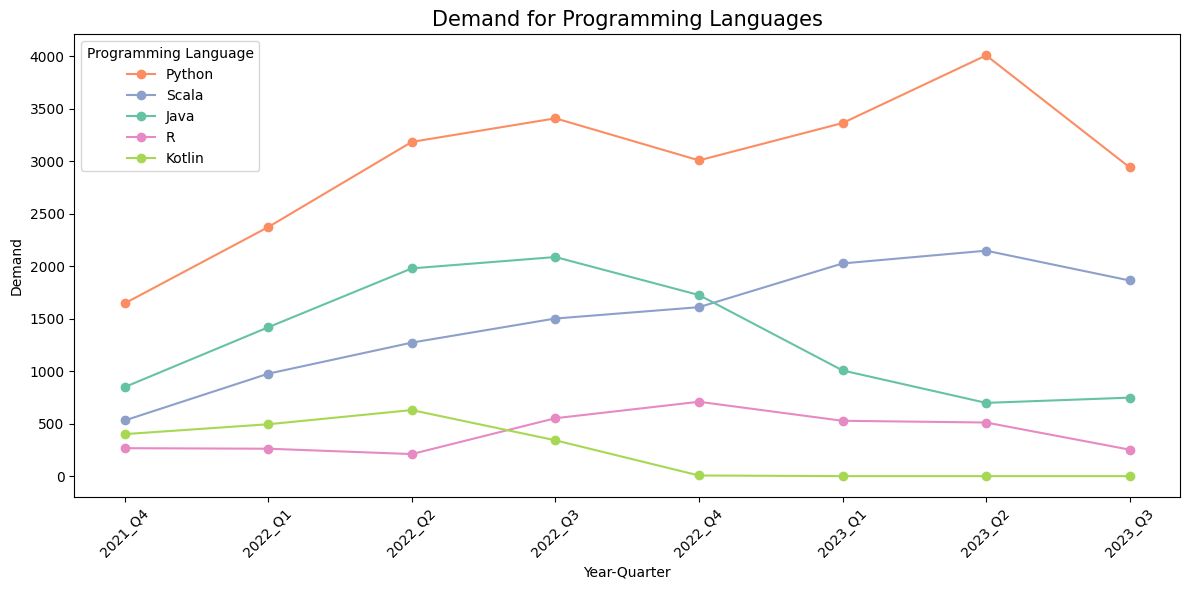

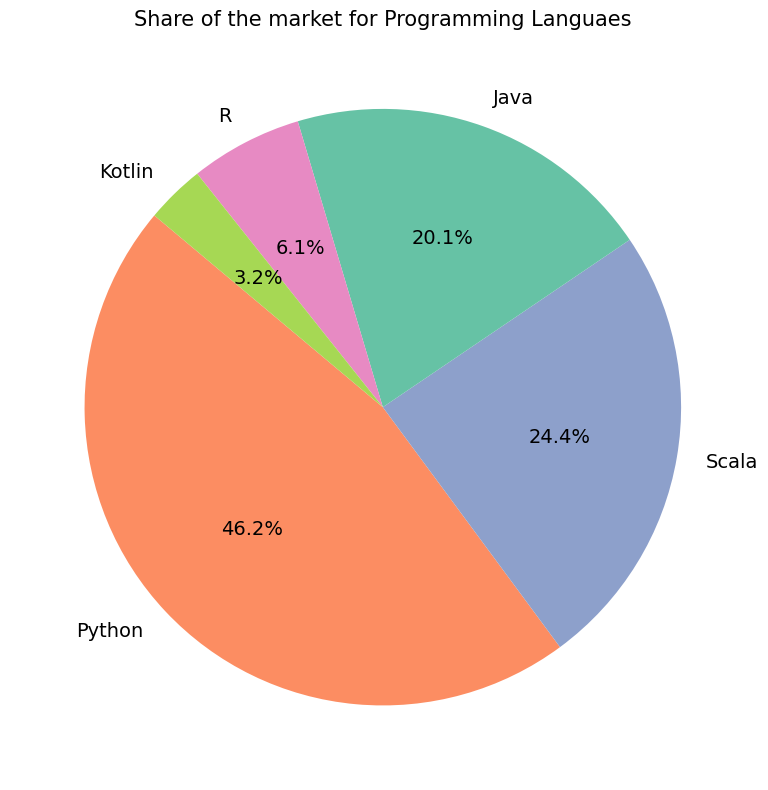

In [ ]:

skills_palette = {
    "Java": plt.cm.Set2(0),
    "Python": plt.cm.Set2(1),
    "Scala": plt.cm.Set2(2),
    "R": plt.cm.Set2(3),
    "Kotlin": plt.cm.Set2(4),
}

total_demand = year_quarter_demand.groupby("skill_name")["count"].sum().reset_index()
total_demand = total_demand.sort_values("count", ascending=False)

ordered_skills = total_demand["skill_name"].tolist()

plt.figure(figsize=(12, 6))

for skill in ordered_skills:
    skill_data = year_quarter_demand[year_quarter_demand["skill_name"] == skill]

    skill_data = skill_data.sort_values(by="year_quarter")

    window_size = 2
    skill_data['smoothed'] = skill_data['count'].rolling(window=window_size, min_periods=1).mean()

    plt.plot(skill_data['year_quarter'], skill_data['smoothed'], label=skill, marker="o", color=skills_palette[skill])

plt.title("Demand for Programming Languages", fontsize=15)
plt.xlabel("Year-Quarter")
plt.ylabel("Demand")
plt.xticks(rotation=45)
plt.legend(title="Programming Language", loc="upper left")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
plt.pie(
    total_demand["count"],
    labels=total_demand["skill_name"],
    autopct="%1.1f%%",
    startangle=140,
    colors=[skills_palette[skill] for skill in total_demand["skill_name"]],
    textprops={'fontsize': 14}
)


plt.title("Share of the market for Programming Languaes", fontsize=15)

plt.tight_layout()
plt.show()


### Average salary for Programming Languages

In [ ]:
popular_skills_prog_salaries = df_salaries.filter(df_salaries["skill_name"].isin(popular_skills_prog))

In [ ]:
df_salaries_pandas = popular_skills_prog_salaries.toPandas()

/tmp/ipykernel_30/1610562050.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivoted_data = df_salaries_pandas.pivot_table(
/tmp/ipykernel_30/1610562050.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set2', len(pivoted_data.columns))  # Choose a color map


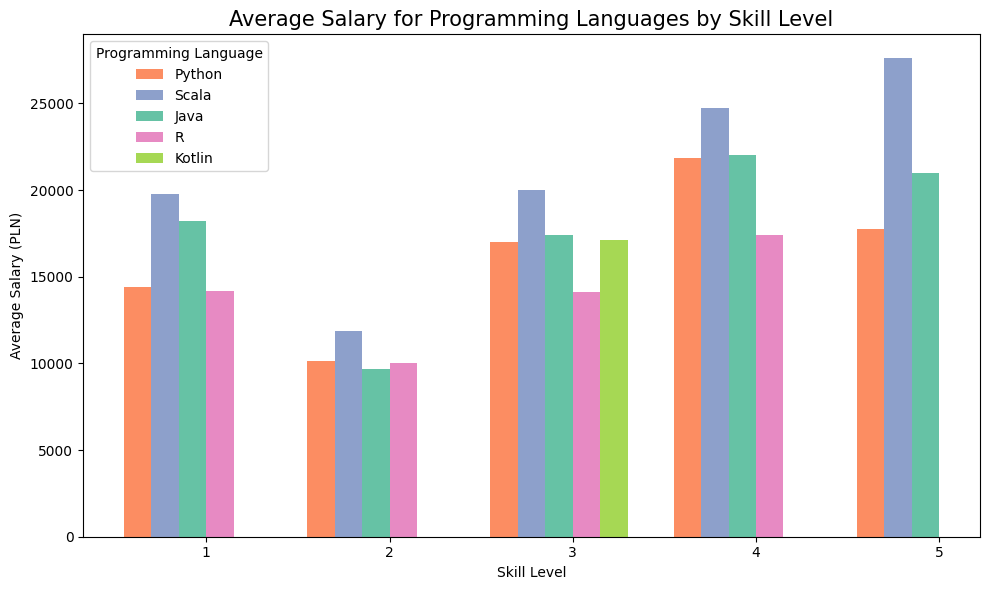

In [ ]:
df_salaries_pandas['skill_name'] = pd.Categorical(df_salaries_pandas['skill_name'], categories=ordered_skills, ordered=True)
df_salaries_pandas = df_salaries_pandas.sort_values('skill_name')

pivoted_data = df_salaries_pandas.pivot_table(
    index='skill_level',
    columns='skill_name',
    values='avg_salary',
    aggfunc='mean'
)

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.15
index = np.arange(len(pivoted_data))

colors = plt.cm.get_cmap('Set2', len(pivoted_data.columns))

for i, skill in enumerate(pivoted_data.columns):
    ax.bar(
        index + (i - len(pivoted_data.columns) / 2) * bar_width,
        pivoted_data[skill],
        bar_width,
        label=skill,
        color=skills_palette[skill]
    )

ax.set_xlabel('Skill Level')
ax.set_ylabel('Average Salary (PLN)')
ax.set_title('Average Salary for Programming Languages by Skill Level', fontsize=15)
ax.set_xticks(index)
ax.set_xticklabels(pivoted_data.index)
ax.legend(title="Programming Language", loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
popular_skills_prog_salaries_experience = df_salaries_experience.filter(df_salaries_experience["skill_name"].isin(popular_skills_prog))
df_salaries_experience_pandas = popular_skills_prog_salaries_experience.toPandas()

/tmp/ipykernel_30/2570271439.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivoted_data = df_salaries_experience_pandas.pivot_table(
/tmp/ipykernel_30/2570271439.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set2', len(pivoted_data.columns))  # Choose a color map


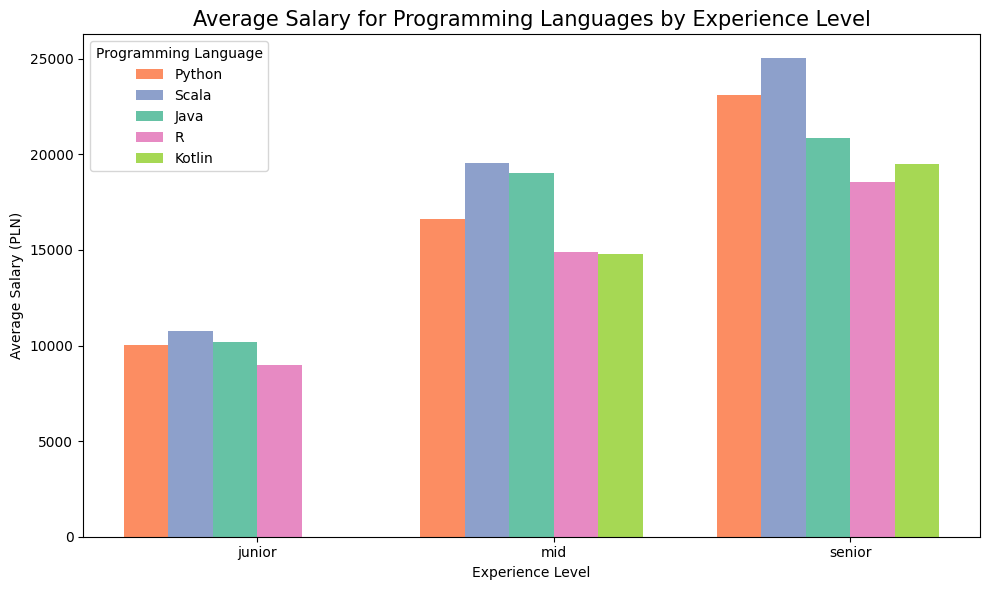

In [ ]:
df_salaries_experience_pandas['skill_name'] = pd.Categorical(df_salaries_experience_pandas['skill_name'], categories=ordered_skills, ordered=True)
df_salaries_experience_pandas = df_salaries_experience_pandas.sort_values('skill_name')

pivoted_data = df_salaries_experience_pandas.pivot_table(
    index='experience_level',
    columns='skill_name',
    values='avg_salary',
    aggfunc='mean'
)

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.15
index = np.arange(len(pivoted_data))

colors = plt.cm.get_cmap('Set2', len(pivoted_data.columns))

for i, skill in enumerate(pivoted_data.columns):
    ax.bar(
        index + (i - len(pivoted_data.columns) / 2) * bar_width,
        pivoted_data[skill],
        bar_width,
        label=skill,
        color=skills_palette[skill]
    )

ax.set_xlabel('Experience Level')
ax.set_ylabel('Average Salary (PLN)')
ax.set_title('Average Salary for Programming Languages by Experience Level', fontsize=15)
ax.set_xticks(index)
ax.set_xticklabels(pivoted_data.index)
ax.legend(title="Programming Language", loc="upper left")
plt.tight_layout()
plt.show()

## Analytics skills

In [ ]:
popular_skills_analytics_df = flattened_skills_year_quater.filter(flattened_skills_year_quater["skill_name"].isin(popular_skills_analytics))

year_quarter_demand_analytics = (
    popular_skills_analytics_df.groupBy("year_quarter", "skill_name")
    .count()
    .orderBy("year_quarter", "skill_name")
    .toPandas()
)

In [ ]:
year_quarters = year_quarter_demand_analytics["year_quarter"].unique()

new_rows = []

for skill in popular_skills_analytics:
    for quarter in year_quarters:
        if not any((year_quarter_demand_analytics["year_quarter"] == quarter) &
                   (year_quarter_demand_analytics["skill_name"] == skill)):
            new_rows.append({
                "year_quarter": quarter,
                "skill_name": skill,
                "count": 0
            })

if new_rows:
    new_df = pd.DataFrame(new_rows)
    year_quarter_demand_analytics = pd.concat([year_quarter_demand_analytics, new_df], ignore_index=True)

In [ ]:
year_quarter_demand_analytics['year_quarter'] = pd.Categorical(
    year_quarter_demand_analytics['year_quarter'],
    categories=sorted(year_quarter_demand_analytics['year_quarter'].unique()),
    ordered=True
)

### Demand for Analytics skills

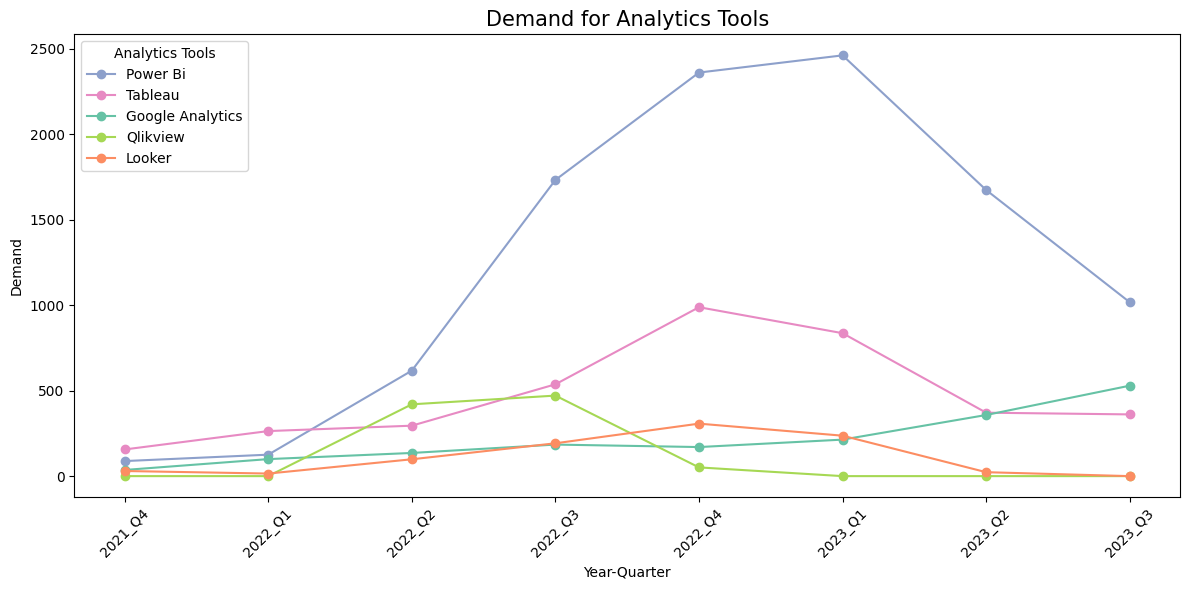

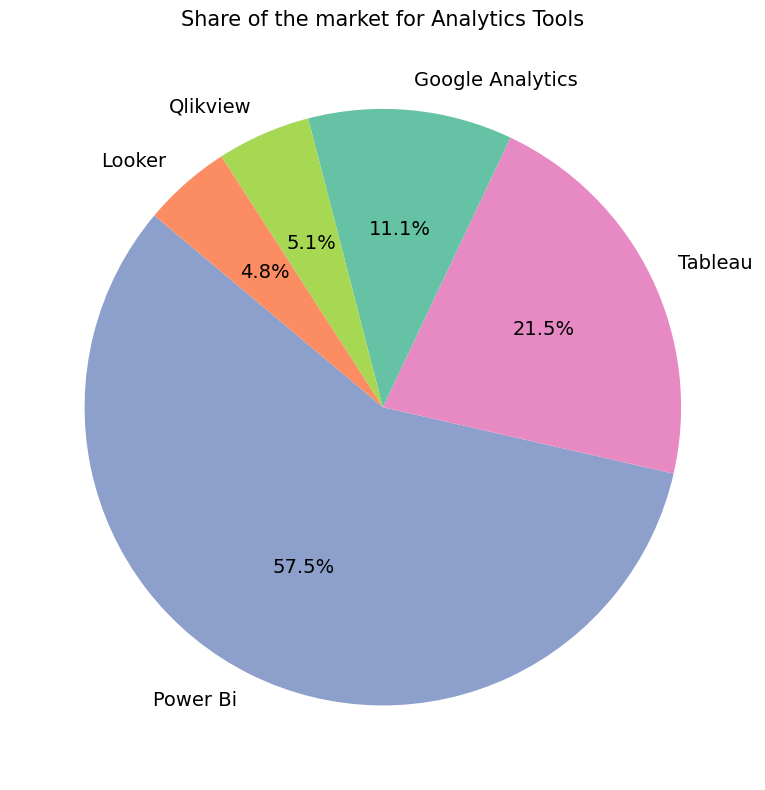

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

skills_palette = {
    "Google Analytics": plt.cm.Set2(0),
    "Looker": plt.cm.Set2(1),
    "Power Bi": plt.cm.Set2(2),
    "Tableau": plt.cm.Set2(3),
    "Qlikview": plt.cm.Set2(4),
}

total_demand = year_quarter_demand_analytics.groupby("skill_name")["count"].sum().reset_index()
total_demand = total_demand.sort_values("count", ascending=False)

ordered_skills = total_demand["skill_name"].tolist()

plt.figure(figsize=(12, 6))

for skill in ordered_skills:
    skill_data = year_quarter_demand_analytics[year_quarter_demand_analytics["skill_name"] == skill]

    skill_data = skill_data.sort_values(by="year_quarter")

    window_size = 2
    skill_data['smoothed'] = skill_data['count'].rolling(window=window_size, min_periods=1).mean()
    plt.plot(skill_data['year_quarter'], skill_data['smoothed'], label=skill, marker="o", color=skills_palette[skill])

plt.title("Demand for Analytics Tools", fontsize=15)
plt.xlabel("Year-Quarter")
plt.ylabel("Demand")
plt.xticks(rotation=45)
plt.legend(title="Analytics Tools", loc="upper left")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
plt.pie(
    total_demand["count"],
    labels=total_demand["skill_name"],
    autopct="%1.1f%%",
    startangle=140,
    colors=[skills_palette[skill] for skill in total_demand["skill_name"]],
    textprops={'fontsize': 14}
)

plt.title("Share of the market for Analytics Tools", fontsize=15)

plt.tight_layout()
plt.show()


In [ ]:
popular_skills_prog_analytics = df_salaries.filter(df_salaries["skill_name"].isin(popular_skills_analytics))
df_salaries_analytics_pandas = popular_skills_prog_analytics.toPandas()
df_salaries_analytics_pandas['skill_name'] = pd.Categorical(df_salaries_analytics_pandas['skill_name'], categories=ordered_skills, ordered=True)
df_salaries_analytics_pandas = df_salaries_analytics_pandas.sort_values('skill_name')

new_rows = []
skill_levels = df_salaries_analytics_pandas["skill_level"].unique()

for skill in popular_skills_analytics:
    for skill_level in skill_levels:
        if not any((df_salaries_analytics_pandas["skill_level"] == skill_level) &
                   (df_salaries_analytics_pandas["skill_name"] == skill)):
            new_rows.append({
                "skill_level": skill_level,
                "skill_name": skill,
                "avg_salary": 0
            })

if new_rows:
    new_df = pd.DataFrame(new_rows)
    df_salaries_analytics_pandas = pd.concat([df_salaries_analytics_pandas, new_df], ignore_index=True)

### Average salary for Analytics skills

/tmp/ipykernel_30/940498847.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set2', len(pivoted_data.columns))  # Choose a color map


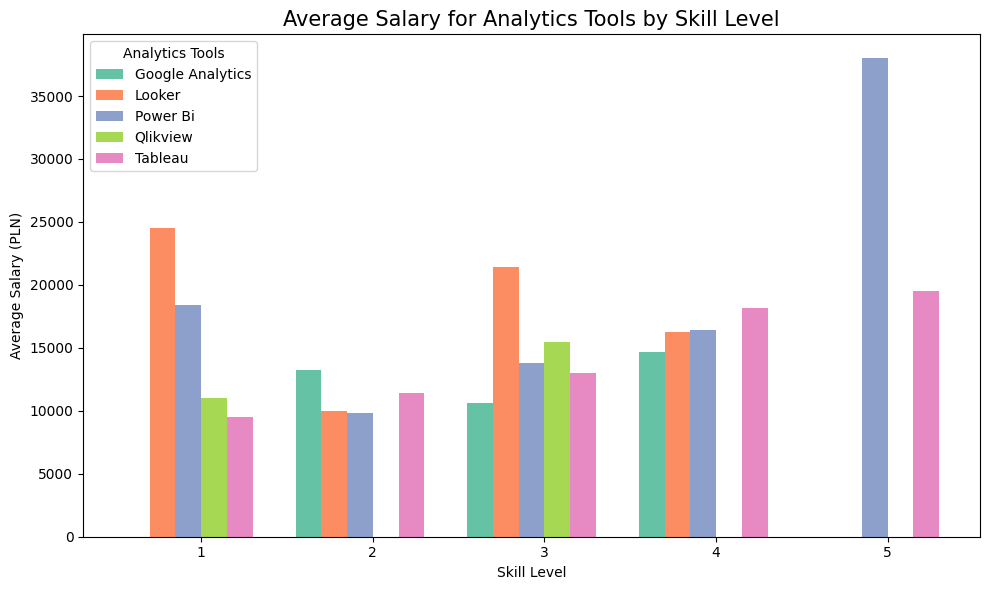

In [ ]:
pivoted_data = df_salaries_analytics_pandas.pivot_table(
    index='skill_level',
    columns='skill_name',
    values='avg_salary',
    aggfunc='mean'
)

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.15
index = np.arange(len(pivoted_data))

colors = plt.cm.get_cmap('Set2', len(pivoted_data.columns))

for i, skill in enumerate(pivoted_data.columns):
    ax.bar(
        index + (i - len(pivoted_data.columns) / 2) * bar_width,
        pivoted_data[skill],
        bar_width,
        label=skill,
        color=skills_palette[skill]
    )

ax.set_xlabel('Skill Level')
ax.set_ylabel('Average Salary (PLN)')
ax.set_title('Average Salary for Analytics Tools by Skill Level', fontsize=15)
ax.set_xticks(index)
ax.set_xticklabels(pivoted_data.index)
ax.legend(title="Analytics Tools", loc="upper left")

plt.tight_layout()
plt.show()

In [ ]:
popular_skills_analytics_salaries_experience = df_salaries_experience.filter(df_salaries_experience["skill_name"].isin(popular_skills_analytics))
df_salaries_analytics_experience_pandas = popular_skills_analytics_salaries_experience.toPandas()
df_salaries_analytics_experience_pandas['skill_name'] = pd.Categorical(df_salaries_analytics_experience_pandas['skill_name'], categories=ordered_skills, ordered=True)
df_salaries_analytics_experience_pandas = df_salaries_analytics_experience_pandas.sort_values('skill_name')

new_rows = []
experience_levels = df_salaries_analytics_experience_pandas["experience_level"].unique()

for skill in popular_skills_analytics:
    for experience_level in experience_levels:
        if not any((df_salaries_analytics_experience_pandas["experience_level"] == experience_level) &
                   (df_salaries_analytics_experience_pandas["skill_name"] == skill)):
            new_rows.append({
                "experience_level": experience_level,
                "skill_name": skill,
                "avg_salary": 0
            })

if new_rows:
    new_df = pd.DataFrame(new_rows)
    df_salaries_analytics_experience_pandas = pd.concat([df_salaries_analytics_experience_pandas, new_df], ignore_index=True)

/tmp/ipykernel_30/1237234026.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set2', len(pivoted_data.columns))  # Choose a color map


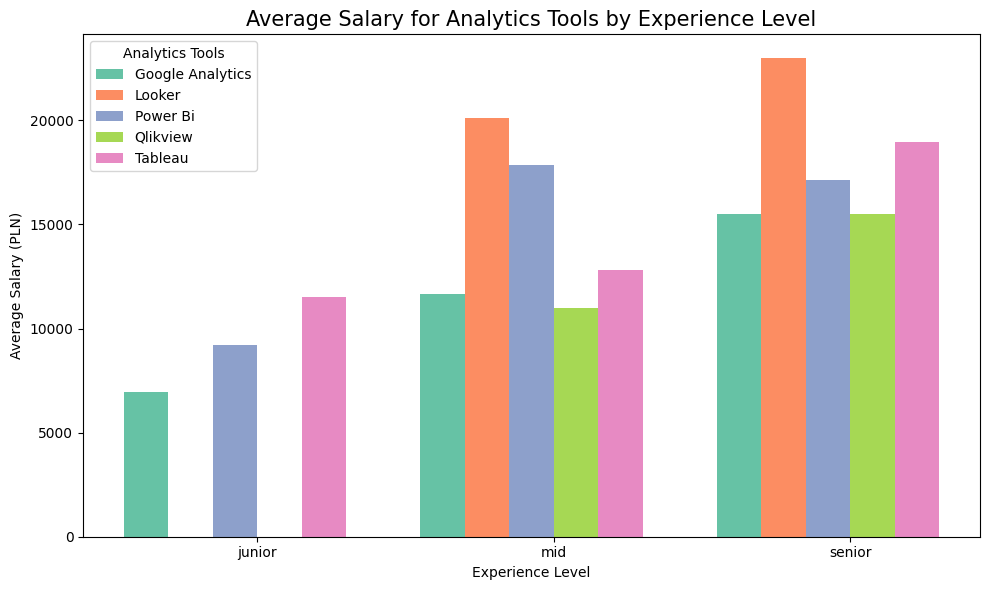

In [ ]:
pivoted_data = df_salaries_analytics_experience_pandas.pivot_table(
    index='experience_level',
    columns='skill_name',
    values='avg_salary',
    aggfunc='mean'
)

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.15
index = np.arange(len(pivoted_data))

colors = plt.cm.get_cmap('Set2', len(pivoted_data.columns))

for i, skill in enumerate(pivoted_data.columns):
    ax.bar(
        index + (i - len(pivoted_data.columns) / 2) * bar_width,
        pivoted_data[skill],
        bar_width,
        label=skill,
        color=skills_palette[skill]
    )

ax.set_xlabel('Experience Level')
ax.set_ylabel('Average Salary (PLN)')
ax.set_title('Average Salary for Analytics Tools by Experience Level', fontsize=15)
ax.set_xticks(index)
ax.set_xticklabels(pivoted_data.index)
ax.legend(title="Analytics Tools", loc="upper left")

plt.tight_layout()
plt.show()


## Cloud Platforms

In [ ]:
popular_skills_cloud_df = flattened_skills_year_quater.filter(flattened_skills_year_quater["skill_name"].isin(popular_skills_cloudPlatforms))

year_quarter_demand_cloud = (
    popular_skills_cloud_df.groupBy("year_quarter", "skill_name")
    .count()
    .orderBy("year_quarter", "skill_name")
    .toPandas()
)

year_quarters = year_quarter_demand_cloud["year_quarter"].unique()

new_rows = []


for skill in popular_skills_cloudPlatforms:
    for quarter in year_quarters:
        if not any((year_quarter_demand_cloud["year_quarter"] == quarter) &
                   (year_quarter_demand_cloud["skill_name"] == skill)):
            new_rows.append({
                "year_quarter": quarter,
                "skill_name": skill,
                "count": 0
            })

if new_rows:
    new_df = pd.DataFrame(new_rows)
    year_quarter_demand_cloud = pd.concat([year_quarter_demand_cloud, new_df], ignore_index=True)

year_quarter_demand_cloud['year_quarter'] = pd.Categorical(
    year_quarter_demand_cloud['year_quarter'],
    categories=sorted(year_quarter_demand_cloud['year_quarter'].unique()),
    ordered=True
)
year_quarter_demand_cloud

### Demand for Cloud Platforms

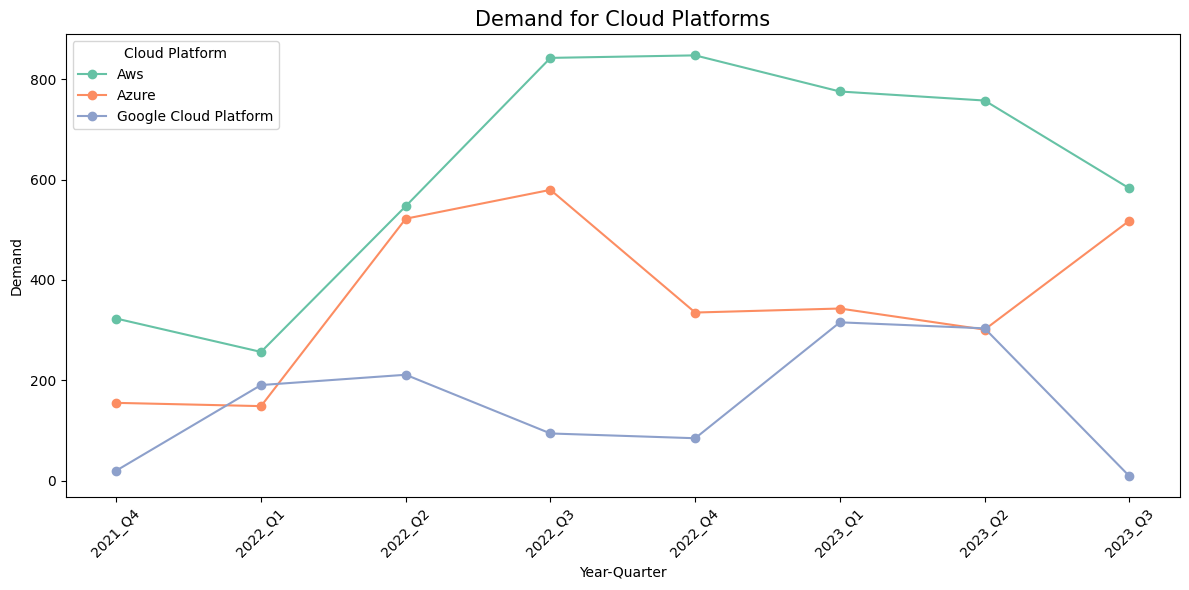

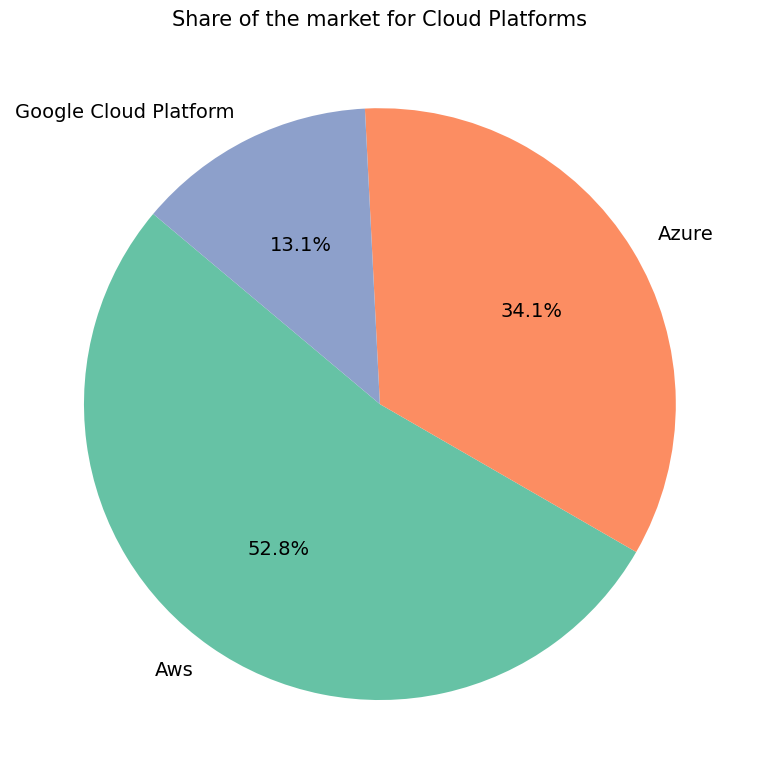

In [ ]:
skills_palette = {
    "Aws": plt.cm.Set2(0),
    "Azure": plt.cm.Set2(1),
    "Google Cloud Platform": plt.cm.Set2(2)
}

total_demand = year_quarter_demand_cloud.groupby("skill_name")["count"].sum().reset_index()
total_demand = total_demand.sort_values("count", ascending=False)

ordered_skills = total_demand["skill_name"].tolist()

plt.figure(figsize=(12, 6))

for skill in ordered_skills:
    skill_data = year_quarter_demand_cloud[year_quarter_demand_cloud["skill_name"] == skill]

    skill_data = skill_data.sort_values(by="year_quarter")

    window_size = 2
    skill_data['smoothed'] = skill_data['count'].rolling(window=window_size, min_periods=1).mean()

    plt.plot(skill_data['year_quarter'], skill_data['smoothed'], label=skill, marker="o", color=skills_palette[skill])

plt.title("Demand for Cloud Platforms", fontsize=15)
plt.xlabel("Year-Quarter")
plt.ylabel("Demand")
plt.xticks(rotation=45)
plt.legend(title="Cloud Platform", loc="upper left")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
plt.pie(
    total_demand["count"],
    labels=total_demand["skill_name"],
    autopct="%1.1f%%",
    startangle=140,
    colors=[skills_palette[skill] for skill in total_demand["skill_name"]],
    textprops={'fontsize': 14}
)

plt.title("Share of the market for Cloud Platforms", fontsize=15)

plt.tight_layout()
plt.show()

### Average salary for Cloud Platforms

In [ ]:
popular_skills_prog_cloud = df_salaries.filter(df_salaries["skill_name"].isin(popular_skills_cloudPlatforms))
df_salaries_cloud_pandas = popular_skills_prog_cloud.toPandas()

df_salaries_cloud_pandas['skill_name'] = pd.Categorical(df_salaries_cloud_pandas['skill_name'], categories=ordered_skills, ordered=True)
df_salaries_cloud_pandas = df_salaries_cloud_pandas.sort_values('skill_name')

new_rows = []
skill_levels = df_salaries_cloud_pandas["skill_level"].unique()

for skill in popular_skills_cloudPlatforms:
    for skill_level in skill_levels:
        if not any((df_salaries_cloud_pandas["skill_level"] == skill_level) &
                   (df_salaries_cloud_pandas["skill_name"] == skill)):
            new_rows.append({
                "skill_level": skill_level,
                "skill_name": skill,
                "avg_salary": 0
            })

if new_rows:
    new_df = pd.DataFrame(new_rows)
    df_salaries_cloud_pandas = pd.concat([df_salaries_cloud_pandas, new_df], ignore_index=True)

/tmp/ipykernel_30/1495368078.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set2', len(pivoted_data.columns))  # Choose a color map


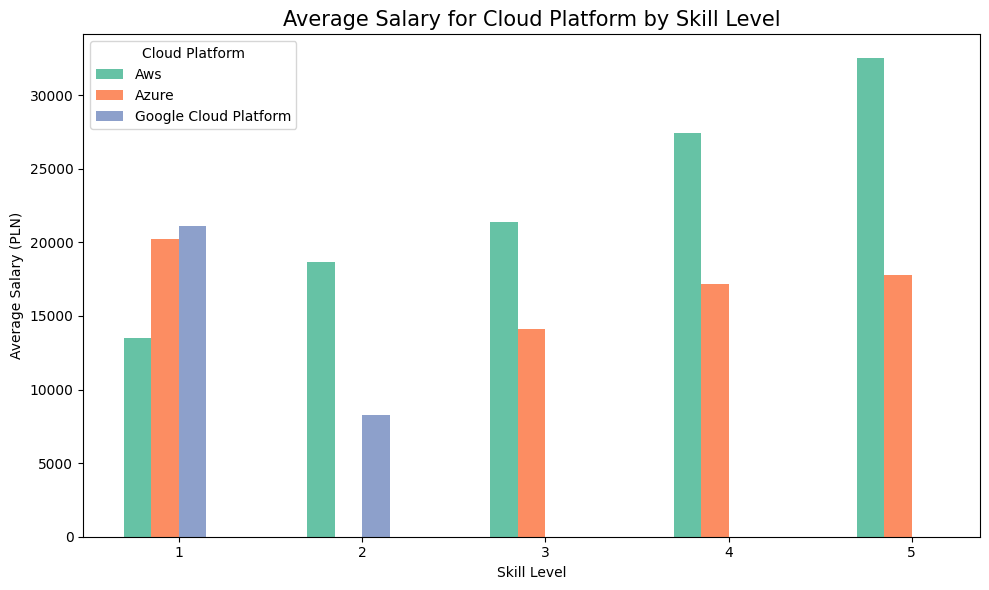

In [ ]:
pivoted_data = df_salaries_cloud_pandas.pivot_table(
    index='skill_level',
    columns='skill_name',
    values='avg_salary',
    aggfunc='mean'
)

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.15
index = np.arange(len(pivoted_data))

colors = plt.cm.get_cmap('Set2', len(pivoted_data.columns))

for i, skill in enumerate(pivoted_data.columns):
    ax.bar(
        index + (i - len(pivoted_data.columns) / 2) * bar_width,
        pivoted_data[skill],
        bar_width,
        label=skill,
        color=skills_palette[skill]
    )


ax.set_xlabel('Skill Level')
ax.set_ylabel('Average Salary (PLN)')
ax.set_title('Average Salary for Cloud Platform by Skill Level', fontsize=15)
ax.set_xticks(index)
ax.set_xticklabels(pivoted_data.index)
ax.legend(title="Cloud Platform", loc="upper left")

plt.tight_layout()
plt.show()

In [ ]:
popular_skills_prog_cloud_experience = df_salaries_experience.filter(df_salaries_experience["skill_name"].isin(popular_skills_cloudPlatforms))
df_salaries_cloud_experience_pandas = popular_skills_prog_cloud_experience.toPandas()

df_salaries_cloud_experience_pandas['skill_name'] = pd.Categorical(df_salaries_cloud_experience_pandas['skill_name'], categories=ordered_skills, ordered=True)
df_salaries_cloud_experience_pandas = df_salaries_cloud_experience_pandas.sort_values('skill_name')

new_rows = []
experience_levels = df_salaries_cloud_experience_pandas["experience_level"].unique()

for skill in popular_skills_cloudPlatforms:
    for experience_level in experience_levels:
        if not any((df_salaries_cloud_experience_pandas["experience_level"] == experience_level) &
                   (df_salaries_cloud_experience_pandas["skill_name"] == skill)):
            new_rows.append({
                "experience_level": experience_level,
                "skill_name": skill,
                "avg_salary": 0
            })

if new_rows:
    new_df = pd.DataFrame(new_rows)
    df_salaries_cloud_experience_pandas = pd.concat([df_salaries_cloud_experience_pandas, new_df], ignore_index=True)

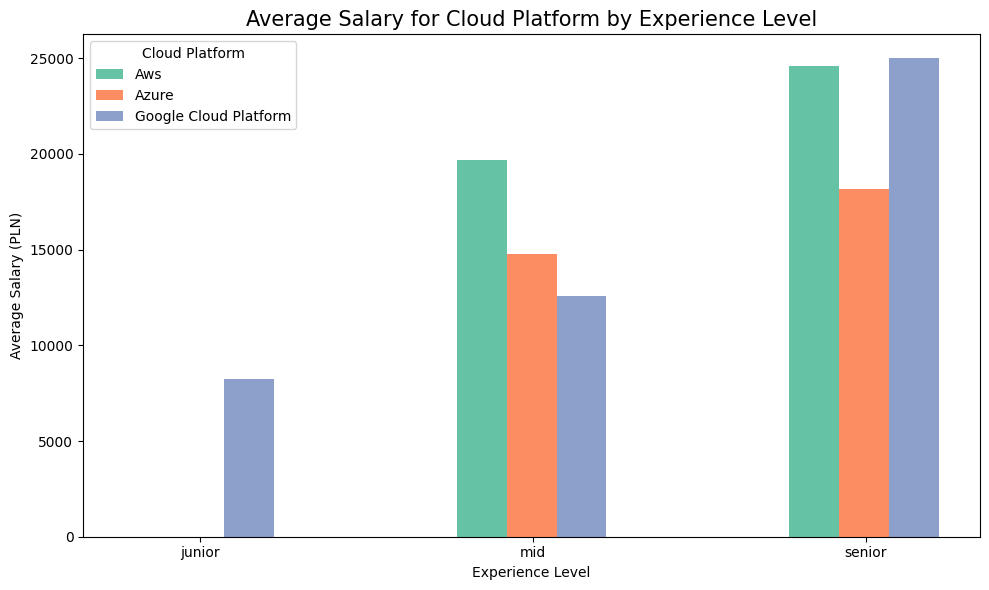

In [ ]:
pivoted_data = df_salaries_cloud_experience_pandas.pivot_table(
    index='experience_level',
    columns='skill_name',
    values='avg_salary',
    aggfunc='mean'
)

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.15
index = np.arange(len(pivoted_data))

for i, skill in enumerate(pivoted_data.columns):
    ax.bar(
        index + (i - len(pivoted_data.columns) / 2) * bar_width,
        pivoted_data[skill],
        bar_width,
        label=skill,
        color=skills_palette[skill]
    )

index = np.arange(len(pivoted_data))

xtick_positions = index - 0.07

ax.set_xticks(xtick_positions)
ax.set_xticklabels(pivoted_data.index)


ax.set_xlabel('Experience Level')
ax.set_ylabel('Average Salary (PLN)')
ax.set_title('Average Salary for Cloud Platform by Experience Level', fontsize=15)

ax.legend(title="Cloud Platform", loc="upper left")
plt.tight_layout()
plt.show()

## Big Data Tools

In [ ]:
popular_skills_bigDataTools_df = flattened_skills_year_quater.filter(flattened_skills_year_quater["skill_name"].isin(popular_skills_bigDataTools))

year_quarter_demand_bigdata = (
    popular_skills_bigDataTools_df.groupBy("year_quarter", "skill_name")
    .count()
    .orderBy("year_quarter", "skill_name")
    .toPandas()
)

year_quarters = year_quarter_demand_bigdata["year_quarter"].unique()

new_rows = []

for skill in popular_skills_bigDataTools:
    for quarter in year_quarters:
        if not any((year_quarter_demand_bigdata["year_quarter"] == quarter) &
                   (year_quarter_demand_bigdata["skill_name"] == skill)):
            new_rows.append({
                "year_quarter": quarter,
                "skill_name": skill,
                "count": 0
            })

if new_rows:
    new_df = pd.DataFrame(new_rows)
    year_quarter_demand_bigdata = pd.concat([year_quarter_demand_bigdata, new_df], ignore_index=True)

year_quarter_demand_bigdata['year_quarter'] = pd.Categorical(
    year_quarter_demand_bigdata['year_quarter'],
    categories=sorted(year_quarter_demand_bigdata['year_quarter'].unique()),
    ordered=True
)
year_quarter_demand_bigdata

### Demand for Big Data Tools

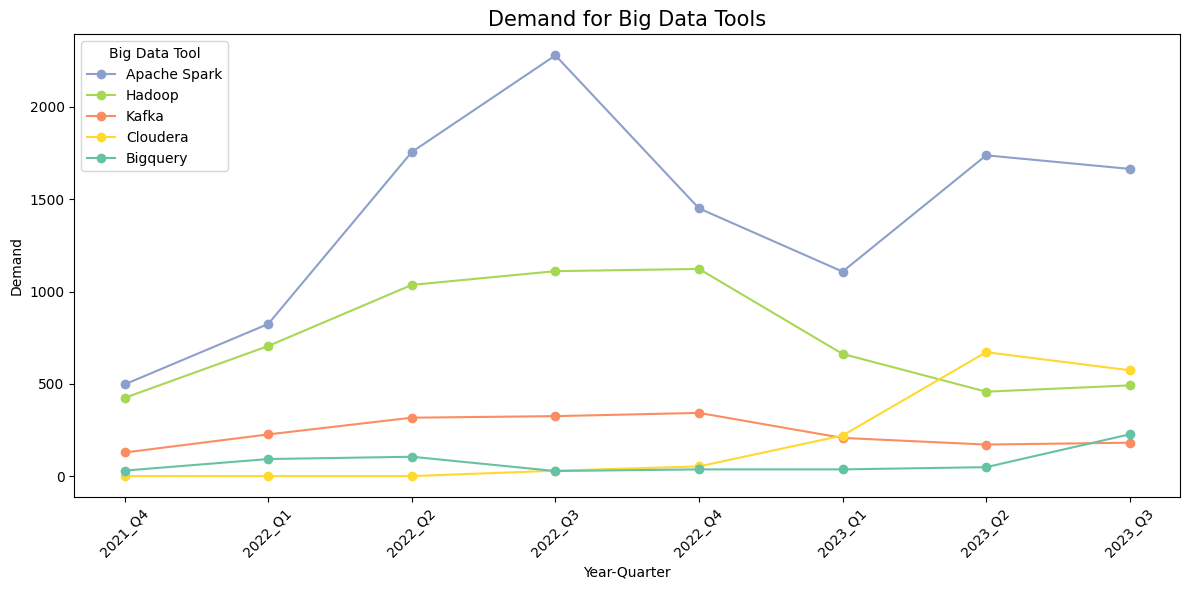

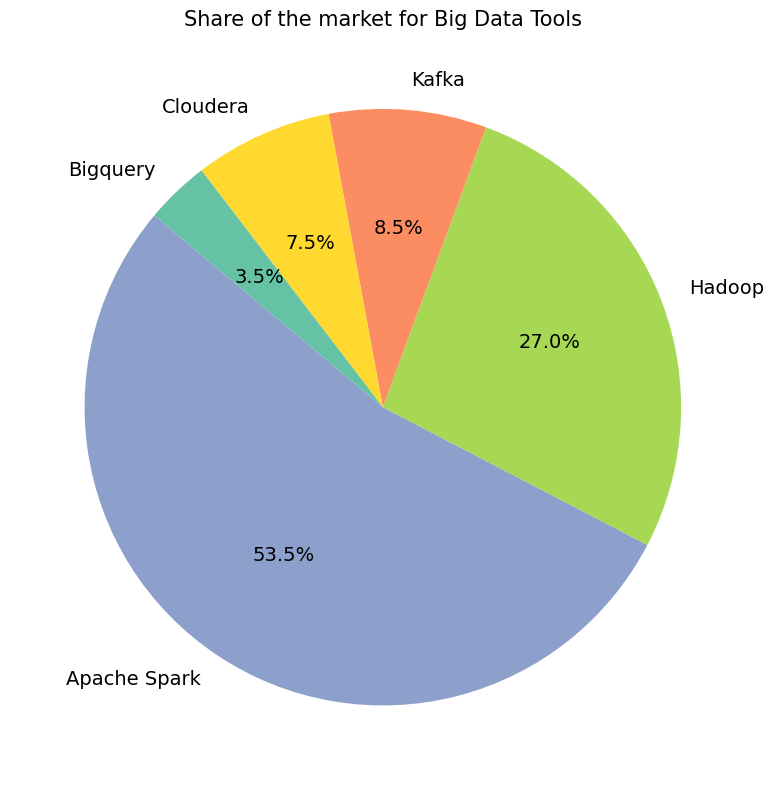

In [ ]:
skills_palette = {
    "Bigquery": plt.cm.Set2(0),
    "Kafka": plt.cm.Set2(1),
    "Apache Spark": plt.cm.Set2(2),
    "Spark": plt.cm.Set2(3),
    "Hadoop": plt.cm.Set2(4),
    "Cloudera": plt.cm.Set2(5),
    "Airflow": plt.cm.Set2(6)

}

total_demand = year_quarter_demand_bigdata.groupby("skill_name")["count"].sum().reset_index()
total_demand = total_demand.sort_values("count", ascending=False)

ordered_skills = total_demand["skill_name"].tolist()

plt.figure(figsize=(12, 6))

for skill in ordered_skills:
    skill_data = year_quarter_demand_bigdata[year_quarter_demand_bigdata["skill_name"] == skill]

    skill_data = skill_data.sort_values(by="year_quarter")

    window_size = 2
    skill_data['smoothed'] = skill_data['count'].rolling(window=window_size, min_periods=1).mean()

    plt.plot(skill_data['year_quarter'], skill_data['smoothed'], label=skill, marker="o", color=skills_palette[skill])

plt.title("Demand for Big Data Tools", fontsize=15)
plt.xlabel("Year-Quarter")
plt.ylabel("Demand")
plt.xticks(rotation=45)
plt.legend(title="Big Data Tool", loc="upper left")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
plt.pie(
    total_demand["count"],
    labels=total_demand["skill_name"],
    autopct="%1.1f%%",
    startangle=140,
    colors=[skills_palette[skill] for skill in total_demand["skill_name"]],
    textprops={'fontsize': 14}
)

plt.title("Share of the market for Big Data Tools", fontsize=15)

plt.tight_layout()
plt.show()

### Average salary for Big Data Tools

In [ ]:
popular_skills_bigdata = df_salaries.filter(df_salaries["skill_name"].isin(popular_skills_bigDataTools))
df_salaries_bigdata_pandas = popular_skills_bigdata.toPandas()
df_salaries_bigdata_pandas['skill_name'] = pd.Categorical(df_salaries_bigdata_pandas['skill_name'], categories=ordered_skills, ordered=True)
df_salaries_bigdata_pandas = df_salaries_bigdata_pandas.sort_values('skill_name')

new_rows = []
skill_levels = df_salaries_bigdata_pandas["skill_level"].unique()

for skill in popular_skills_bigDataTools:
    for skill_level in skill_levels:
        if not any((df_salaries_bigdata_pandas["skill_level"] == skill_level) &
                   (df_salaries_bigdata_pandas["skill_name"] == skill)):
            new_rows.append({
                "skill_level": skill_level,
                "skill_name": skill,
                "avg_salary": 0
            })

if new_rows:
    new_df = pd.DataFrame(new_rows)
    df_salaries_bigdata_pandas = pd.concat([df_salaries_bigdata_pandas, new_df], ignore_index=True)

/tmp/ipykernel_30/209646763.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set2', len(pivoted_data.columns))  # Choose a color map


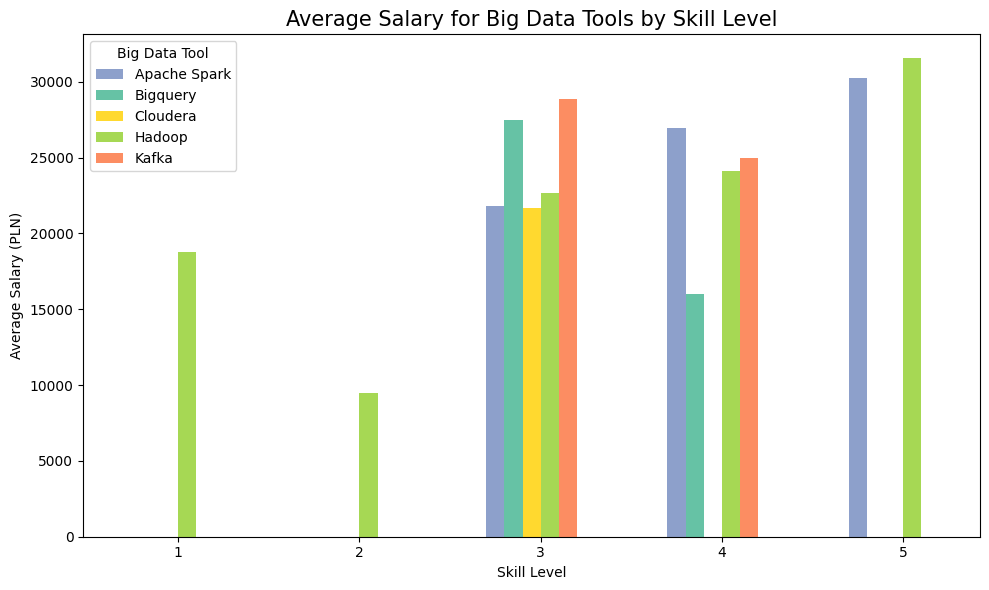

In [ ]:
pivoted_data = df_salaries_bigdata_pandas.pivot_table(
    index='skill_level',
    columns='skill_name',
    values='avg_salary',
    aggfunc='mean'
)

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.1
index = np.arange(len(pivoted_data))

colors = plt.cm.get_cmap('Set2', len(pivoted_data.columns))

for i, skill in enumerate(pivoted_data.columns):
    ax.bar(
        index + (i - len(pivoted_data.columns) / 2) * bar_width,
        pivoted_data[skill],
        bar_width,
        label=skill,
        color=skills_palette[skill]
    )

ax.set_xlabel('Skill Level')
ax.set_ylabel('Average Salary (PLN)')
ax.set_title('Average Salary for Big Data Tools by Skill Level', fontsize=15)
ax.set_xticks(index)
ax.set_xticklabels(pivoted_data.index)
ax.legend(title="Big Data Tool", loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
popular_skills_bigData_experience = df_salaries_experience.filter(df_salaries_experience["skill_name"].isin(popular_skills_bigDataTools))
df_salaries_bigdata_experience_pandas = popular_skills_bigData_experience.toPandas()
df_salaries_bigdata_experience_pandas['skill_name'] = pd.Categorical(df_salaries_bigdata_experience_pandas['skill_name'], categories=ordered_skills, ordered=True)
df_salaries_bigdata_experience_pandas = df_salaries_bigdata_experience_pandas.sort_values('skill_name')

new_rows = []
experience_levels = df_salaries_bigdata_experience_pandas["experience_level"].unique()

for skill in popular_skills_bigDataTools:
    for experience_level in experience_levels:
        if not any((df_salaries_bigdata_experience_pandas["experience_level"] == experience_level) &
                   (df_salaries_bigdata_experience_pandas["skill_name"] == skill)):
            new_rows.append({
                "experience_level": experience_level,
                "skill_name": skill,
                "avg_salary": 0
            })

if new_rows:
    new_df = pd.DataFrame(new_rows)
    df_salaries_bigdata_experience_pandas = pd.concat([df_salaries_bigdata_experience_pandas, new_df], ignore_index=True)

/tmp/ipykernel_30/2770259153.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set2', len(pivoted_data.columns))  # Choose a color map


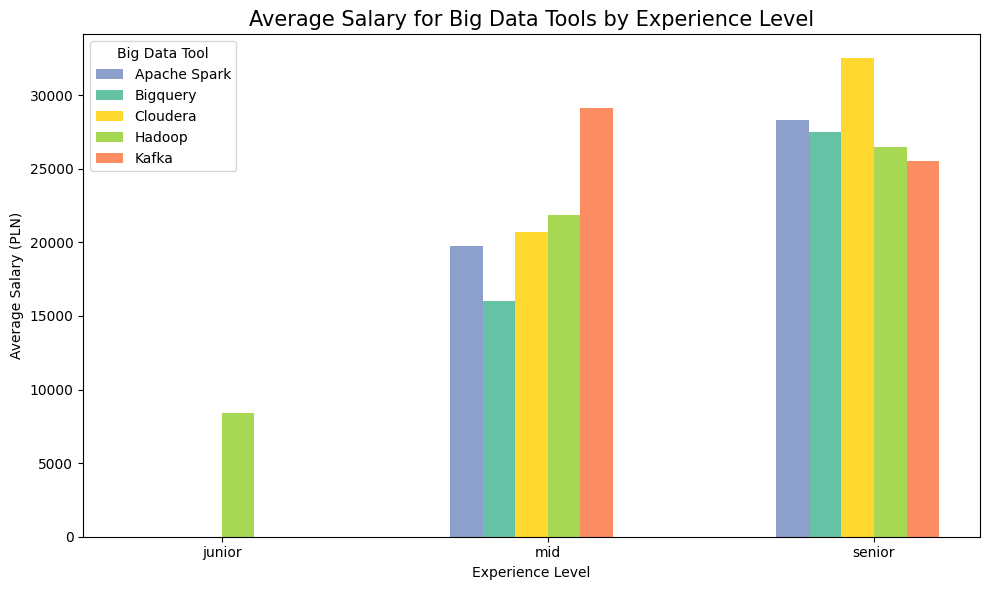

In [ ]:
pivoted_data = df_salaries_bigdata_experience_pandas.pivot_table(
    index='experience_level',
    columns='skill_name',
    values='avg_salary',
    aggfunc='mean'
)

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.1
index = np.arange(len(pivoted_data))

colors = plt.cm.get_cmap('Set2', len(pivoted_data.columns))

for i, skill in enumerate(pivoted_data.columns):
    ax.bar(
        index + (i - len(pivoted_data.columns) / 2) * bar_width,
        pivoted_data[skill],
        bar_width,
        label=skill,
        color=skills_palette[skill]
    )

ax.set_xlabel('Experience Level')
ax.set_ylabel('Average Salary (PLN)')
ax.set_title('Average Salary for Big Data Tools by Experience Level', fontsize=15)
ax.set_xticks(index)
ax.set_xticklabels(pivoted_data.index)
ax.legend(title="Big Data Tool", loc="upper left")

plt.tight_layout()
plt.show()

## Databases

In [ ]:
popular_skills_sql_df = flattened_skills_year_quater.filter(flattened_skills_year_quater["skill_name"].isin(popular_skills_sql))

year_quarter_demand_sql = (
    popular_skills_sql_df.groupBy("year_quarter", "skill_name")
    .count()
    .orderBy("year_quarter", "skill_name")
    .toPandas()
)

year_quarters = year_quarter_demand_sql["year_quarter"].unique()

new_rows = []

for skill in popular_skills_sql:
    for quarter in year_quarters:
        if not any((year_quarter_demand_sql["year_quarter"] == quarter) &
                   (year_quarter_demand_sql["skill_name"] == skill)):
            new_rows.append({
                "year_quarter": quarter,
                "skill_name": skill,
                "count": 0
            })

if new_rows:
    new_df = pd.DataFrame(new_rows)
    year_quarter_demand_sql = pd.concat([year_quarter_demand_sql, new_df], ignore_index=True)

year_quarter_demand_sql['year_quarter'] = pd.Categorical(
    year_quarter_demand_sql['year_quarter'],
    categories=sorted(year_quarter_demand_sql['year_quarter'].unique()),
    ordered=True
)
year_quarter_demand_sql

### Demand for Databases

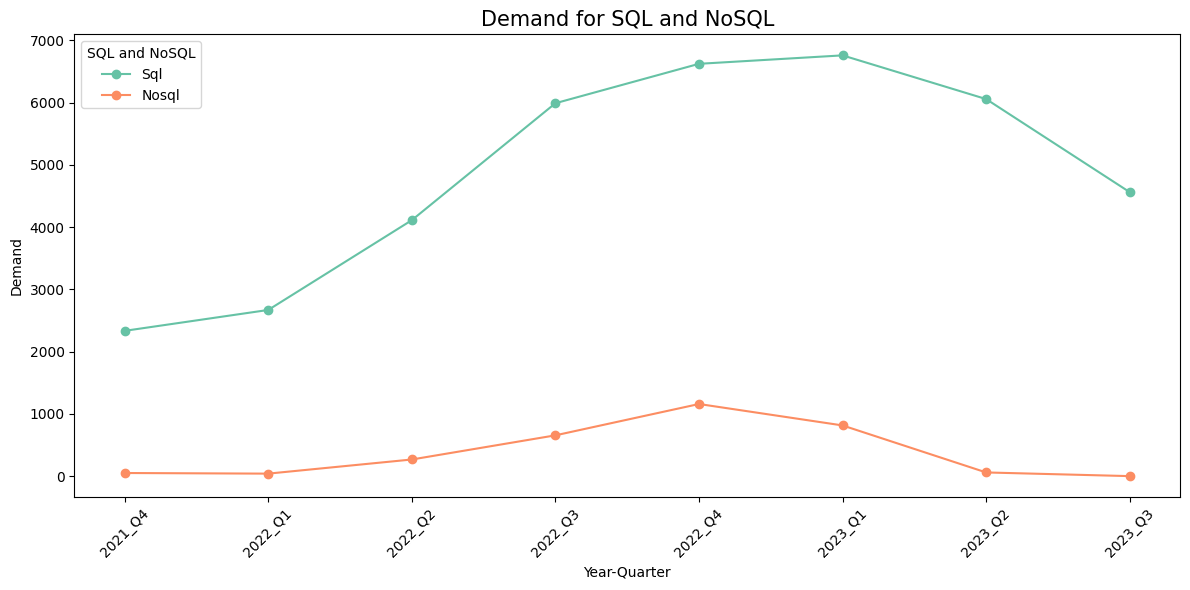

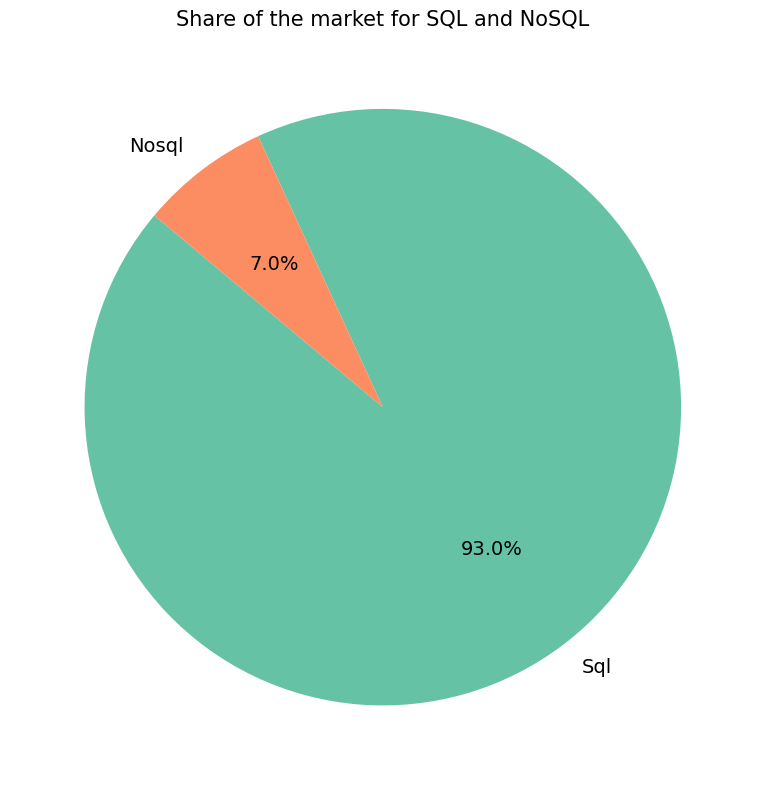

In [ ]:
skills_palette = {
    "Sql": plt.cm.Set2(0),
    "Nosql": plt.cm.Set2(1)
}

total_demand = year_quarter_demand_sql.groupby("skill_name")["count"].sum().reset_index()
total_demand = total_demand.sort_values("count", ascending=False)

ordered_skills = total_demand["skill_name"].tolist()

plt.figure(figsize=(12, 6))

for skill in ordered_skills:
    skill_data = year_quarter_demand_sql[year_quarter_demand_sql["skill_name"] == skill]

    skill_data = skill_data.sort_values(by="year_quarter")

    window_size = 2
    skill_data['smoothed'] = skill_data['count'].rolling(window=window_size, min_periods=1).mean()

    plt.plot(skill_data['year_quarter'], skill_data['smoothed'], label=skill, marker="o", color=skills_palette[skill])

plt.title("Demand for SQL and NoSQL", fontsize=15)
plt.xlabel("Year-Quarter")
plt.ylabel("Demand")
plt.xticks(rotation=45)
plt.legend(title="SQL and NoSQL", loc="upper left")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
plt.pie(
    total_demand["count"],
    labels=total_demand["skill_name"],
    autopct="%1.1f%%",
    startangle=140,
    colors=[skills_palette[skill] for skill in total_demand["skill_name"]],
    textprops={'fontsize': 14}
)

plt.title("Share of the market for SQL and NoSQL", fontsize=15)

plt.tight_layout()
plt.show()

### Average salary for databases

In [ ]:
popular_skills_sql = df_salaries.filter(df_salaries["skill_name"].isin(popular_skills_sql))
df_salaries_sql_pandas = popular_skills_sql.toPandas()

/tmp/ipykernel_30/627698894.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivoted_data = df_salaries_sql_pandas.pivot_table(
/tmp/ipykernel_30/627698894.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set2', len(pivoted_data.columns))  # Choose a color map


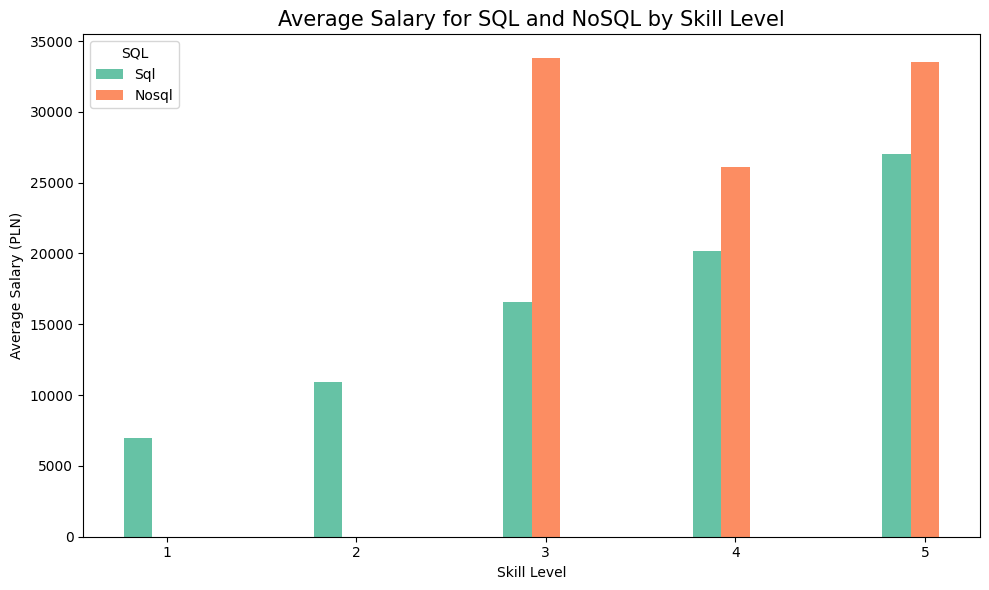

In [ ]:
df_salaries_sql_pandas['skill_name'] = pd.Categorical(df_salaries_sql_pandas['skill_name'], categories=ordered_skills, ordered=True)
df_salaries_sql_pandas = df_salaries_sql_pandas.sort_values('skill_name')

pivoted_data = df_salaries_sql_pandas.pivot_table(
    index='skill_level',
    columns='skill_name',
    values='avg_salary',
    aggfunc='mean'
)

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.15
index = np.arange(len(pivoted_data))

colors = plt.cm.get_cmap('Set2', len(pivoted_data.columns))

for i, skill in enumerate(pivoted_data.columns):
    ax.bar(
        index + (i - len(pivoted_data.columns) / 2) * bar_width,
        pivoted_data[skill],
        bar_width,
        label=skill,
        color=skills_palette[skill]
    )

ax.set_xlabel('Skill Level')
ax.set_ylabel('Average Salary (PLN)')
ax.set_title('Average Salary for SQL and NoSQL by Skill Level', fontsize=15)
ax.set_xticks(index)
ax.set_xticklabels(pivoted_data.index)
ax.legend(title="SQL", loc="upper left")

plt.tight_layout()
plt.show()

In [ ]:
popular_skills_sql = ['Sql','Nosql']
popular_skills_sql_experience = df_salaries_experience.filter(df_salaries_experience["skill_name"].isin(popular_skills_sql))
df_salaries_sql_experience_pandas = popular_skills_sql_experience.toPandas()

In [ ]:
df_salaries_sql_experience_pandas
df_salaries_sql_experience_pandas['skill_name'] = pd.Categorical(df_salaries_sql_experience_pandas['skill_name'], categories=ordered_skills, ordered=True)
df_salaries_sql_experience_pandas = df_salaries_sql_experience_pandas.sort_values('skill_name')

In [ ]:
new_rows = []
experience_levels = df_salaries_sql_experience_pandas["experience_level"].unique()

for skill in popular_skills_sql:
    for experience_level in experience_levels:
        if not any((df_salaries_sql_experience_pandas["experience_level"] == experience_level) &
                   (df_salaries_sql_experience_pandas["skill_name"] == skill)):
            new_rows.append({
                "experience_level": experience_level,
                "skill_name": skill,
                "avg_salary": 0,
                "offer_count": 0
            })

if new_rows:
    new_df = pd.DataFrame(new_rows)
    df_salaries_sql_experience_pandas = pd.concat([df_salaries_sql_experience_pandas, new_df], ignore_index=True)

/tmp/ipykernel_30/2125560435.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivoted_data = df_salaries_sql_experience_pandas.pivot_table(


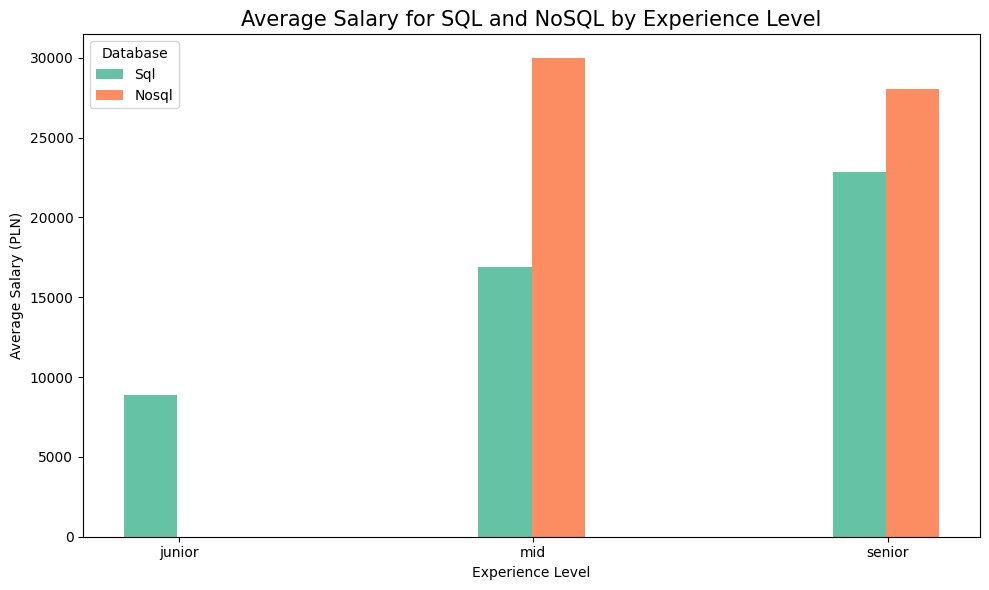

In [ ]:
df_salaries_sql_experience_pandas['skill_name'] = pd.Categorical(df_salaries_sql_experience_pandas['skill_name'], categories=ordered_skills, ordered=True)
df_salaries_sql_experience_pandas = df_salaries_sql_experience_pandas.sort_values('skill_name')

pivoted_data = df_salaries_sql_experience_pandas.pivot_table(
    index='experience_level',
    columns='skill_name',
    values='avg_salary',
    aggfunc='mean'
)

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.15
num_skills = len(pivoted_data.columns)
index = np.arange(len(pivoted_data))

for i, skill in enumerate(pivoted_data.columns):
    ax.bar(
        index + (i - num_skills / 2) * bar_width,
        pivoted_data[skill],
        bar_width,
        label=skill,
        color=skills_palette[skill]
    )


xtick_positions = index - 0.07

ax.set_xticks(xtick_positions)
ax.set_xticklabels(pivoted_data.index)

ax.set_xlabel('Experience Level')
ax.set_ylabel('Average Salary (PLN)')
ax.set_title('Average Salary for SQL and NoSQL by Experience Level', fontsize=15)

ax.legend(title="Database", loc="upper left")

plt.tight_layout()
plt.show()


## General skills

In [ ]:
popular_skills_general_df = flattened_skills_year_quater.filter(flattened_skills_year_quater["skill_name"].isin(popular_skills_general))

year_quarter_demand_general = (
    popular_skills_general_df.groupBy("year_quarter", "skill_name")
    .count()
    .orderBy("year_quarter", "skill_name")
    .toPandas()
)

year_quarters = year_quarter_demand_general["year_quarter"].unique()

new_rows = []

for skill in popular_skills_general:
    for quarter in year_quarters:
        if not any((year_quarter_demand_general["year_quarter"] == quarter) &
                   (year_quarter_demand_general["skill_name"] == skill)):
            new_rows.append({
                "year_quarter": quarter,
                "skill_name": skill,
                "count": 0
            })

if new_rows:
    new_df = pd.DataFrame(new_rows)
    year_quarter_demand_general = pd.concat([year_quarter_demand_general, new_df], ignore_index=True)

year_quarter_demand_general['year_quarter'] = pd.Categorical(
    year_quarter_demand_general['year_quarter'],
    categories=sorted(year_quarter_demand_general['year_quarter'].unique()),
    ordered=True
)
year_quarter_demand_general

### Demand for General Skills

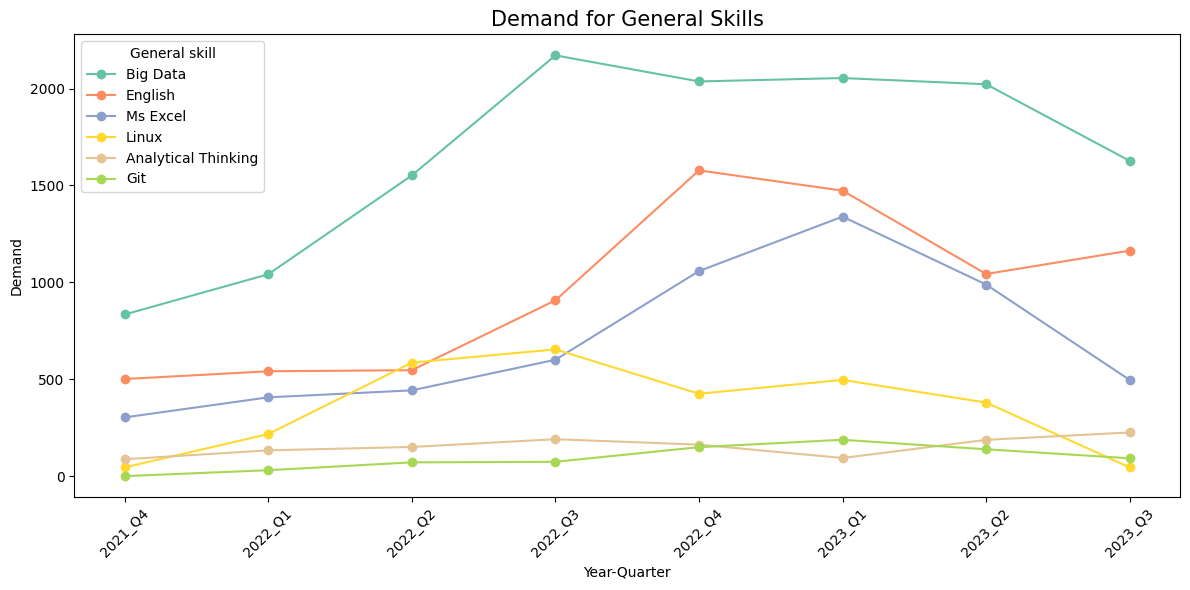

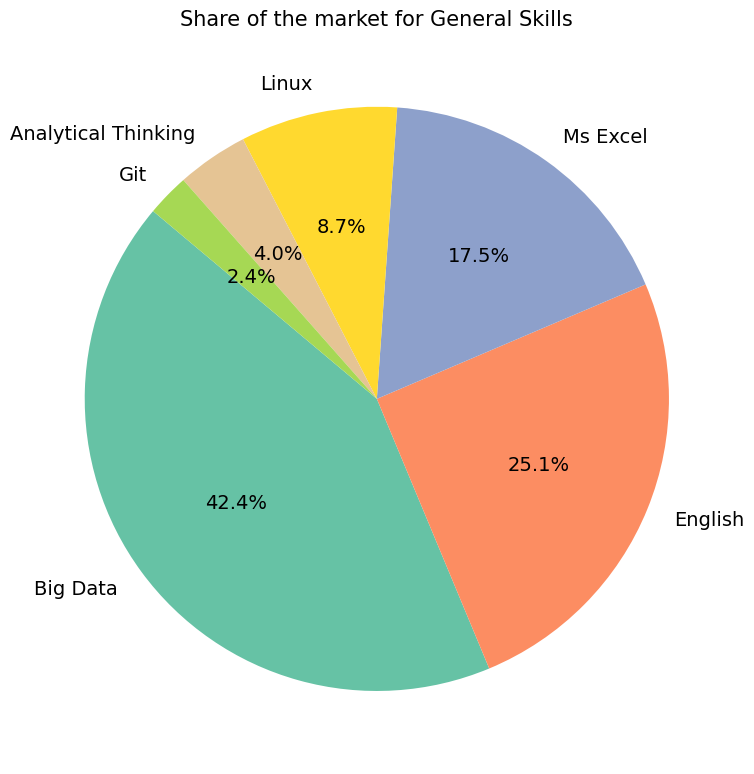

In [ ]:
skills_palette = {
    "Big Data": plt.cm.Set2(0),
    "English": plt.cm.Set2(1),
    "Ms Excel": plt.cm.Set2(2),
    "Etl": plt.cm.Set2(3),
    "Git": plt.cm.Set2(4),
    "Linux": plt.cm.Set2(5),
    "Analytical Thinking": plt.cm.Set2(6),
}

total_demand = year_quarter_demand_general.groupby("skill_name")["count"].sum().reset_index()
total_demand = total_demand.sort_values("count", ascending=False)

ordered_skills = total_demand["skill_name"].tolist()

plt.figure(figsize=(12, 6))

for skill in ordered_skills:
    skill_data = year_quarter_demand_general[year_quarter_demand_general["skill_name"] == skill]

    skill_data = skill_data.sort_values(by="year_quarter")

    window_size = 2
    skill_data['smoothed'] = skill_data['count'].rolling(window=window_size, min_periods=1).mean()

    plt.plot(skill_data['year_quarter'], skill_data['smoothed'], label=skill, marker="o", color=skills_palette[skill])

plt.title("Demand for General Skills", fontsize=15)
plt.xlabel("Year-Quarter")
plt.ylabel("Demand")
plt.xticks(rotation=45)
plt.legend(title="General skill", loc="upper left")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
plt.pie(
    total_demand["count"],
    labels=total_demand["skill_name"],
    autopct="%1.1f%%",
    startangle=140,
    colors=[skills_palette[skill] for skill in total_demand["skill_name"]],
    textprops={'fontsize': 14}
)

plt.title("Share of the market for General Skills", fontsize=15)

plt.tight_layout()
plt.show()

In [ ]:
popular_skills_general = df_salaries.filter(df_salaries["skill_name"].isin(popular_skills_general))
df_salaries_general_pandas = popular_skills_general.toPandas()

### Average salary for General Skills

/tmp/ipykernel_30/161587869.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivoted_data = df_salaries_general_pandas.pivot_table(
/tmp/ipykernel_30/161587869.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set2', len(pivoted_data.columns))  # Choose a color map


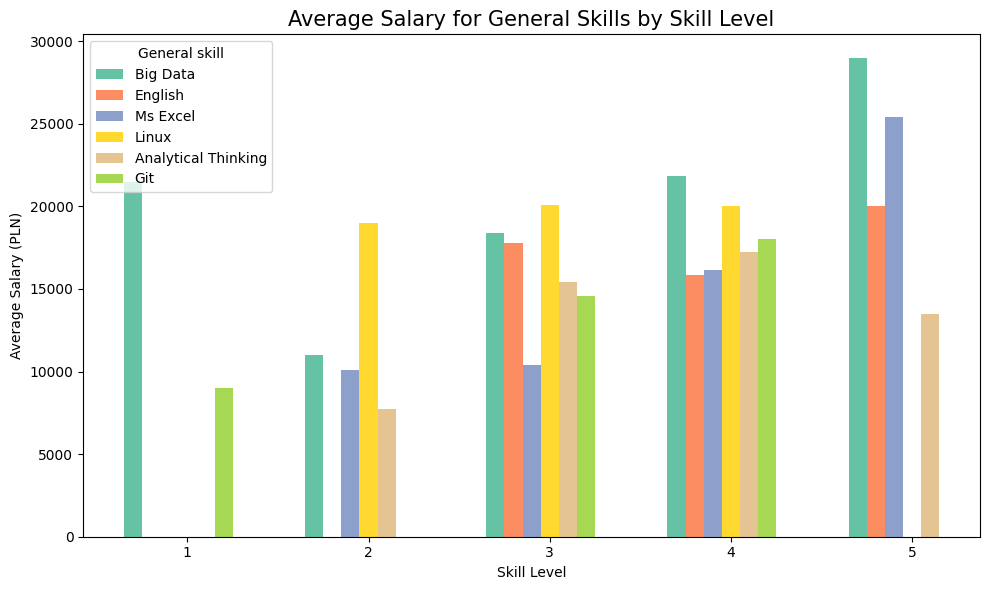

In [ ]:
df_salaries_general_pandas['skill_name'] = pd.Categorical(df_salaries_general_pandas['skill_name'], categories=ordered_skills, ordered=True)
df_salaries_general_pandas = df_salaries_general_pandas.sort_values('skill_name')

pivoted_data = df_salaries_general_pandas.pivot_table(
    index='skill_level',
    columns='skill_name',
    values='avg_salary',
    aggfunc='mean'
)

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.1
index = np.arange(len(pivoted_data))

colors = plt.cm.get_cmap('Set2', len(pivoted_data.columns))

for i, skill in enumerate(pivoted_data.columns):
    ax.bar(
        index + (i - len(pivoted_data.columns) / 2) * bar_width,
        pivoted_data[skill],
        bar_width,
        label=skill,
        color=skills_palette[skill]
    )

ax.set_xlabel('Skill Level')
ax.set_ylabel('Average Salary (PLN)')
ax.set_title('Average Salary for General Skills by Skill Level', fontsize=15)
ax.set_xticks(index)
ax.set_xticklabels(pivoted_data.index)
ax.legend(title="General skill", loc="upper left")

plt.tight_layout()
plt.show()

In [ ]:
popular_skills_general = ["Big Data","English","Ms Excel", "Git", "Linux", "Analytical Thinking"]
popular_skills_general_experience = df_salaries_experience.filter(df_salaries_experience["skill_name"].isin(popular_skills_general))
df_salaries_general_experience_pandas = popular_skills_general_experience.toPandas()

/tmp/ipykernel_30/1371945082.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivoted_data = df_salaries_general_experience_pandas.pivot_table(
/tmp/ipykernel_30/1371945082.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set2', len(pivoted_data.columns))  # Choose a color map


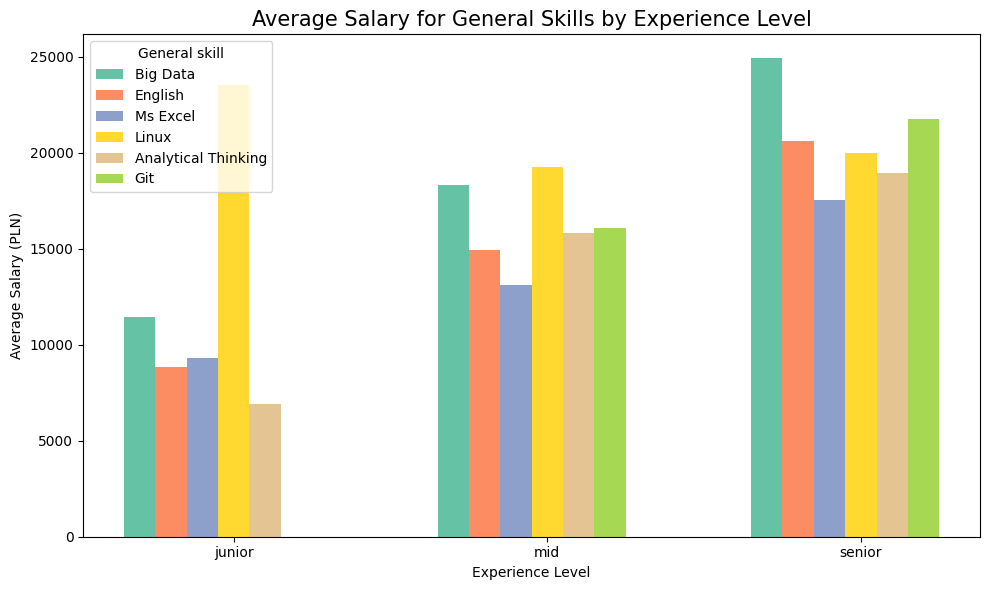

In [ ]:
df_salaries_general_experience_pandas['skill_name'] = pd.Categorical(df_salaries_general_experience_pandas['skill_name'], categories=ordered_skills, ordered=True)
df_salaries_general_experience_pandas = df_salaries_general_experience_pandas.sort_values('skill_name')

pivoted_data = df_salaries_general_experience_pandas.pivot_table(
    index='experience_level',
    columns='skill_name',
    values='avg_salary',
    aggfunc='mean'
)

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.1
index = np.arange(len(pivoted_data))

colors = plt.cm.get_cmap('Set2', len(pivoted_data.columns))

for i, skill in enumerate(pivoted_data.columns):
    ax.bar(
        index + (i - len(pivoted_data.columns) / 2) * bar_width,
        pivoted_data[skill],
        bar_width,
        label=skill,
        color=skills_palette[skill]
    )

ax.set_xlabel('Experience Level')
ax.set_ylabel('Average Salary (PLN)')
ax.set_title('Average Salary for General Skills by Experience Level', fontsize=15)
ax.set_xticks(index)
ax.set_xticklabels(pivoted_data.index)
ax.legend(title="General skill", loc="upper left")

plt.tight_layout()
plt.show()

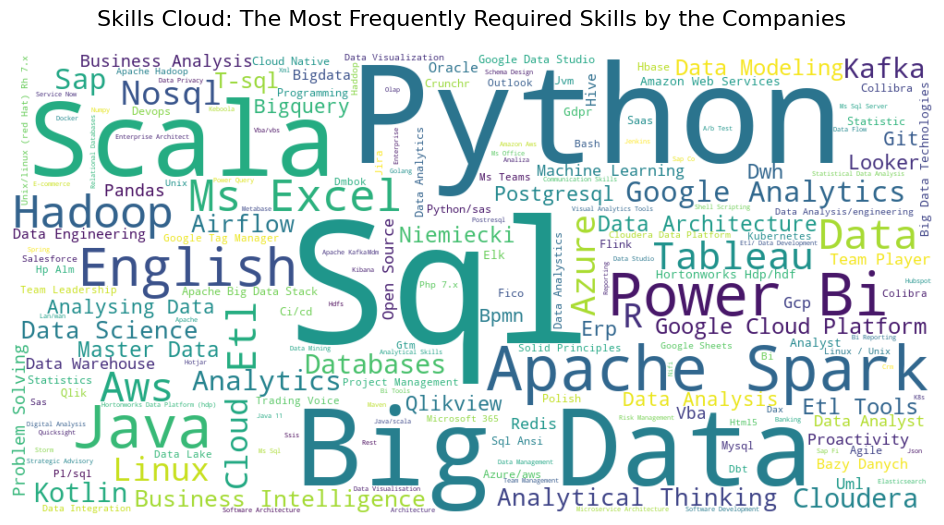

In [ ]:
skills_dict = dict(zip(most_frequent_skills_pd['skill_name'], most_frequent_skills_pd['count']))

wordcloud = WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(skills_dict)

plt.figure(figsize=(20, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Skills Cloud: The Most Frequently Required Skills by the Companies", fontsize=16, pad=20)
plt.axis('off')
plt.show()